In [1]:
import threading
import time
import torch
import psutil  # 新增：资源监控
from RESNETEE import *
from openood.networks import ResNet18_32x32
from spliter import *
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset

# === 资源监控函数 ===
def print_resource_usage():
    # GPU memory usage
    allocated = torch.cuda.memory_allocated() / (1024 ** 2)  # MB
    reserved = torch.cuda.memory_reserved() / (1024 ** 2)    # MB

    # CPU usage
    cpu_percent = psutil.cpu_percent(interval=None)
    mem = psutil.virtual_memory()
    mem_used = mem.used / (1024 ** 2)
    mem_total = mem.total / (1024 ** 2)

    print(f"[资源监控] GPU分配: {allocated:.1f} MB | GPU保留: {reserved:.1f} MB | CPU占用: {cpu_percent:.1f}% | 内存使用: {mem_used:.1f}/{mem_total:.1f} MB")

# === 模型加载 ===
base_model = ResNet18_32x32(num_classes=10)
model_with_exits = ResNet18AutoEarlyExits(resnet=base_model)
model_with_exits.load_state_dict(torch.load('model_with_exits.pth'))
model_with_exits.cuda()
model_with_exits.train()  # 默认开启训练模式以支持后续 retrain

# === 数据加载 ===
train_dataset_1, train_dataset_2, test_dataset = split_cifar10_dataset()
print(f'Dataset 1 size: {len(train_dataset_1)}')
print(f'Dataset 2 size: {len(train_dataset_2)}')

train_loader_1 = DataLoader(train_dataset_1, batch_size=64, shuffle=True)
train_loader_2 = DataLoader(train_dataset_2, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# === 同步锁 ===
model_lock = threading.Lock()

# === 推理线程 ===
def inference_loop():
    model_with_exits.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.cuda()
            labels = labels.cuda()
            with model_lock:
                outputs, exits = model_with_exits(inputs, auto_select=True)
            print(f"[推理] 第 {i} 个样本完成，出口位置: Exit{exits}")
            print_resource_usage()
            time.sleep(0.2)  # 控制推理速率

# === retrain 线程（只更新 exit1）===
def retrain_loop():
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model_with_exits.early_exit1.parameters(), lr=0.01)

    while True:
        model_with_exits.train()
        inputs = torch.randn(1, 3, 32, 32).cuda()
        targets = torch.randint(0, 10, (1,)).cuda()
        with model_lock:
            output, _ = model_with_exits(inputs, return_exit1=True)
            loss = criterion(output, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print("[训练] 训练了一次 exit1")
        print_resource_usage()
        time.sleep(1.5)



C:\Users\Zhao\AppData\Local\Temp\ipykernel_16096\1606252020.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_with_exits.load_state_dict(torch.load('model_with_exit

Files already downloaded and verified
Files already downloaded and verified
Dataset 1 size: 25000
Dataset 2 size: 25000


In [2]:
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from collections import defaultdict, Counter
def evaluate_and_log(model, dataloader, thresholds=(0.8872, 0.5428), device='cuda', force_exit=None): 
    model.eval()
    logs = {
        'logits': [],
        'confs': [],
        'preds': [],
        'labels': [],
        'exits': [],
    }

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # 强制使用某个出口（用于 A 模式或分析）
            if force_exit == 1:
                outputs, _ = model(images, return_exit1=True)
                exit_ids = torch.ones(len(images), dtype=torch.long)  # 标记 exit1
            elif force_exit == 2:
                outputs, _ = model(images, return_exit2=True)
                exit_ids = torch.ones(len(images), dtype=torch.long) * 2  # 标记 exit2
            elif force_exit == 3:
                outputs, _ = model(images)
                exit_ids = torch.ones(len(images), dtype=torch.long) * 3  # 标记 exit3
            else:
                # 使用自动 early exit 模式
                outputs, exit_ids = model(
                    images,
                    auto_select=True,
                    threshold1=thresholds[0],
                    threshold2=thresholds[1]
                )

            # 获取 softmax 概率与置信度预测
            probs = F.softmax(outputs, dim=1)
            confs, preds = torch.max(probs, dim=1)

            # 逐个样本记录日志
            logs['logits'].extend(outputs.cpu())
            logs['confs'].extend(confs.cpu())
            logs['preds'].extend(preds.cpu())
            logs['labels'].extend(labels.cpu())
            logs['exits'].extend(exit_ids.cpu())

    return logs


def extract_exit_dataset(logs, exit_id):
    samples = [
        (log, pred) for log, pred, eid in zip(logs['logits'], logs['preds'], logs['exits']) if eid == exit_id
    ]
    if not samples:
        return None
    logits, preds = zip(*samples)
    logits = torch.stack(logits)
    preds = torch.tensor(preds)
    return TensorDataset(logits, preds)


def summarize_exits(logs):
    exit_counts = defaultdict(int)
    correct_counts = defaultdict(int)
    total = len(logs['labels'])

    for pred, label, exit_id in zip(logs['preds'], logs['labels'], logs['exits']):
        exit_counts[exit_id.item()] += 1
        if pred == label:
            correct_counts[exit_id.item()] += 1

    print("\n Exit Summary:")
    for exit_id in sorted(exit_counts.keys()):
        count = exit_counts[exit_id]
        correct = correct_counts[exit_id]
        acc = correct / count if count > 0 else 0
        print(f"  Exit {exit_id}: {count} samples, Accuracy = {acc:.2%}")

    overall_acc = sum(p == t for p, t in zip(logs['preds'], logs['labels'])) / total
    print(f"   Overall Accuracy: {overall_acc:.2%}")
    
def plot_exit_distribution(logs):
    counts = Counter([eid.item() for eid in logs['exits']])
    exits = sorted(counts.keys())
    values = [counts[e] for e in exits]

    plt.figure(figsize=(6, 4))
    plt.bar([f"Exit {e}" for e in exits], values, color='skyblue')
    plt.title(" Sample Distribution Across Exits")
    plt.xlabel("Exit Used")
    plt.ylabel("Number of Samples")
    plt.tight_layout()
    plt.show()
def per_class_accuracy(logs, class_names):
    correct_per_class = defaultdict(int)
    total_per_class = defaultdict(int)

    for pred, label in zip(logs['preds'], logs['labels']):
        cls = label.item()
        total_per_class[cls] += 1
        if pred == label:
            correct_per_class[cls] += 1

    print("\n Per-Class Accuracy:")
    for i, name in enumerate(class_names):
        total = total_per_class[i]
        correct = correct_per_class[i]
        acc = correct / total if total > 0 else 0
        print(f"  {name:<12}: {acc:.2%} ({correct}/{total})")
        
def exit_class_heatmap(logs, class_names):
    exit_class_counts = defaultdict(lambda: defaultdict(int))

    for label, exit_id in zip(logs['labels'], logs['exits']):
        exit_class_counts[exit_id.item()][label.item()] += 1

    exits = sorted(exit_class_counts.keys())
    matrix = []
    for eid in exits:
        row = [exit_class_counts[eid][i] for i in range(len(class_names))]
        matrix.append(row)

    plt.figure(figsize=(10, 4))
    sns.heatmap(np.array(matrix), annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=[f"Exit {e}" for e in exits])
    plt.xlabel("Class")
    plt.ylabel("Exit Used")
    plt.title("Heatmap of Class Distribution per Exit")
    plt.tight_layout()
    plt.show()
def print_exit_byclass_table(logs, class_names):
    exit_class_counts = defaultdict(lambda: defaultdict(int))
    for label, exit_id in zip(logs['labels'], logs['exits']):
        exit_class_counts[exit_id.item()][label.item()] += 1

    exits = sorted(exit_class_counts.keys())

    header = f"{'Class':<12} | " + " | ".join([f"Exit {e:<3}" for e in exits])
    print("\n Exit-Class 分布统计表")
    print(header)
    print("-" * len(header))

    for i, cls_name in enumerate(class_names):
        row = f"{cls_name:<12} | "
        row += " | ".join([f"{exit_class_counts[e].get(i, 0):<7}" for e in exits])
        print(row)


In [3]:
from plot_and_evaluate import *
# Example usage
id_classes  = ['airplane', 'automobile', 'bird', 'cat'] 
ood_classes = ['ship', 'truck','deer', 'dog', 'frog', 'horse']

# Assuming `model` and `testloader` are already defined
evaluate_EE_byclass(model_with_exits, test_loader, id_classes, ood_classes, return_exit1=True, return_exit2=False)

Accuracy for class airplane: 93.40%
Accuracy for class automobile: 94.90%
Accuracy for class bird: 0.60%
Accuracy for class cat: 0.90%
Accuracy for class deer: 2.40%
Accuracy for class dog: 4.30%
Accuracy for class frog: 6.50%
Accuracy for class horse: 0.20%
Accuracy for class ship: 92.50%
Accuracy for class truck: 95.70%
Accuracy for ID classes: 47.45%
Accuracy for OOD classes: 33.60%


In [4]:
evaluate_EE_byclass(model_with_exits, test_loader, id_classes, ood_classes, return_exit1=False, return_exit2=True)

Accuracy for class airplane: 96.40%
Accuracy for class automobile: 97.90%
Accuracy for class bird: 88.40%
Accuracy for class cat: 0.40%
Accuracy for class deer: 95.90%
Accuracy for class dog: 95.60%
Accuracy for class frog: 0.00%
Accuracy for class horse: 1.30%
Accuracy for class ship: 96.80%
Accuracy for class truck: 95.20%
Accuracy for ID classes: 70.78%
Accuracy for OOD classes: 64.13%


In [5]:
evaluate_EE_byclass(model_with_exits, test_loader, id_classes, ood_classes, return_exit1=False, return_exit2=False)

Accuracy for class airplane: 95.90%
Accuracy for class automobile: 98.20%
Accuracy for class bird: 92.50%
Accuracy for class cat: 88.60%
Accuracy for class deer: 97.00%
Accuracy for class dog: 92.20%
Accuracy for class frog: 95.60%
Accuracy for class horse: 96.40%
Accuracy for class ship: 96.60%
Accuracy for class truck: 96.30%
Accuracy for ID classes: 93.80%
Accuracy for OOD classes: 95.68%



 Exit Summary:
  Exit 1: 4065 samples, Accuracy = 88.86%
  Exit 2: 2904 samples, Accuracy = 93.80%
  Exit 3: 3031 samples, Accuracy = 92.74%
   Overall Accuracy: 91.47%


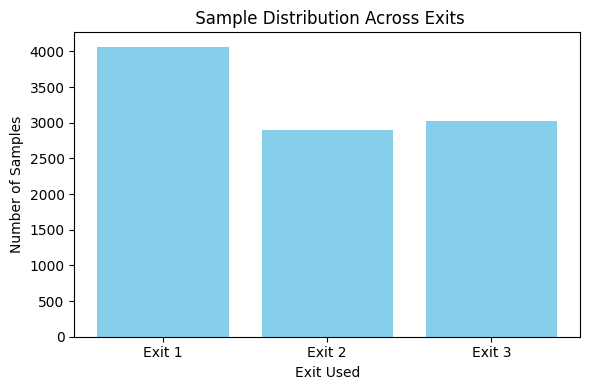


 Per-Class Accuracy:
  airplane    : 95.00% (950/1000)
  automobile  : 96.70% (967/1000)
  bird        : 82.70% (827/1000)
  cat         : 81.10% (811/1000)
  deer        : 93.30% (933/1000)
  dog         : 90.00% (900/1000)
  frog        : 93.40% (934/1000)
  horse       : 90.70% (907/1000)
  ship        : 95.40% (954/1000)
  truck       : 96.40% (964/1000)


In [9]:
logs = evaluate_and_log(model_with_exits, test_loader, thresholds=(0.9, 0.9))
summarize_exits(logs)
plot_exit_distribution(logs)
per_class_accuracy(logs, class_names)
exit3_ds = extract_exit_dataset(logs, exit_id=3)

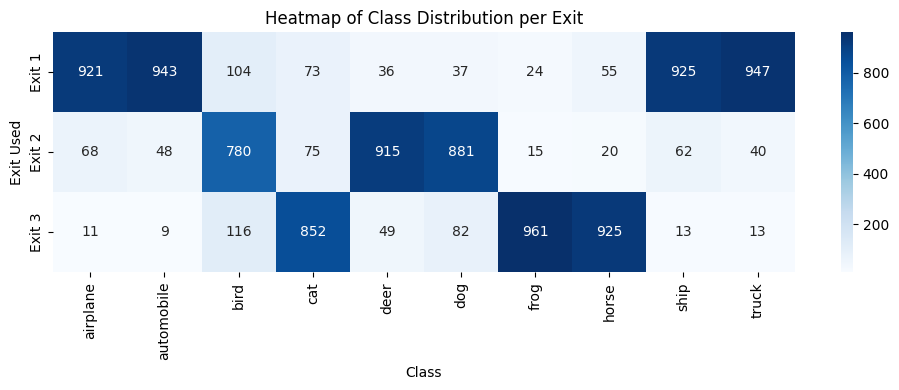


 Exit-Class 分布统计表
Class        | Exit 1   | Exit 2   | Exit 3  
---------------------------------------------
airplane     | 921     | 68      | 11     
automobile   | 943     | 48      | 9      
bird         | 104     | 780     | 116    
cat          | 73      | 75      | 852    
deer         | 36      | 915     | 49     
dog          | 37      | 881     | 82     
frog         | 24      | 15      | 961    
horse        | 55      | 20      | 925    
ship         | 925     | 62      | 13     
truck        | 947     | 40      | 13     


In [10]:
exit_class_heatmap(logs, class_names)
print_exit_byclass_table(logs, class_names)

In [4]:
import random
from torch.utils.data import Subset

def filter_by_samples(dataset, classes_ratios, seed=None):
    rng = random.Random(seed)
    indices = []
    
    # 确定类别到索引的映射
    if hasattr(dataset, 'class_to_idx'):
        class_to_idx = dataset.class_to_idx
    else:
        class_to_idx = {cls: idx for idx, cls in enumerate(dataset.classes)}
    
    # 收集所有样本的标签
    if hasattr(dataset, 'targets'):
        labels = dataset.targets
    elif hasattr(dataset, 'samples'):
        labels = [label for (_, label) in dataset.samples]
    else:
        labels = []
        for i in range(len(dataset)):
            _, label = dataset[i]
            labels.append(label)
    
    # 处理每个类别
    for cls, ratio in classes_ratios.items():
        if cls not in class_to_idx:
            raise ValueError(f"Class {cls} not found in dataset.")
        
        class_idx = class_to_idx[cls]
        class_indices = [i for i, label in enumerate(labels) if label == class_idx]
        
        if not class_indices:
            continue
        
        # 计算样本数量并确保有效性
        num_samples = int(len(class_indices) * ratio)
        num_samples = max(0, min(num_samples, len(class_indices)))
        
        if num_samples == 0:
            continue
        
        # 随机抽样
        selected = rng.sample(class_indices, num_samples)
        indices.extend(selected)
    
    # 打乱整体顺序
    rng.shuffle(indices)
    return Subset(dataset, indices)
# 定义不同类别的样本比例
classes_ratios = {
    'airplane': 0.8,    # 4个类别各80%
    'automobile': 0.8,
    'bird': 0.8,
    'cat': 0.8,
    'deer': 0.6,        # 3个类别各60%
    'dog': 0.6,
    'frog': 0.6,
    'horse': 0.1,       # 剩余3个类别各10%
    'ship': 0.1,
    'truck': 0.1
}

# 创建子集

subset = filter_by_samples(test_dataset, classes_ratios, seed=42)

# 查看结果
print(f"Total samples in subset: {len(subset)}")
from collections import Counter

# 获取原始类别分布
original_counts = Counter(test_dataset.targets)

# 获取子集类别分布
subset_labels = [test_dataset.targets[i] for i in subset.indices]
subset_counts = Counter(subset_labels)

# 打印结果
for cls, idx in test_dataset.class_to_idx.items():
    original = original_counts[idx]
    subset_number = subset_counts.get(idx, 0)
    ratio = classes_ratios.get(cls, 0)
    print(f"{cls:10} | Original: {original:4} | Subset: {subset_number:4} | Target Ratio: {ratio:.0%} | Actual Ratio: {subset_number/original:.1%}")

Total samples in subset: 5300
airplane   | Original: 1000 | Subset:  800 | Target Ratio: 80% | Actual Ratio: 80.0%
automobile | Original: 1000 | Subset:  800 | Target Ratio: 80% | Actual Ratio: 80.0%
bird       | Original: 1000 | Subset:  800 | Target Ratio: 80% | Actual Ratio: 80.0%
cat        | Original: 1000 | Subset:  800 | Target Ratio: 80% | Actual Ratio: 80.0%
deer       | Original: 1000 | Subset:  600 | Target Ratio: 60% | Actual Ratio: 60.0%
dog        | Original: 1000 | Subset:  600 | Target Ratio: 60% | Actual Ratio: 60.0%
frog       | Original: 1000 | Subset:  600 | Target Ratio: 60% | Actual Ratio: 60.0%
horse      | Original: 1000 | Subset:  100 | Target Ratio: 10% | Actual Ratio: 10.0%
ship       | Original: 1000 | Subset:  100 | Target Ratio: 10% | Actual Ratio: 10.0%
truck      | Original: 1000 | Subset:  100 | Target Ratio: 10% | Actual Ratio: 10.0%


In [5]:
new_distribution_loader= DataLoader(subset, batch_size=64, shuffle=True)
from plot_and_evaluate import *
# Example usage
id_classes  = ['airplane', 'automobile', 'bird', 'cat'] 
ood_classes = ['ship', 'truck','deer', 'dog', 'frog', 'horse']
evaluate_EE_byclass(model_with_exits, new_distribution_loader, id_classes, ood_classes, return_exit1=True, return_exit2=False)

Accuracy for class airplane: 93.25%
Accuracy for class automobile: 94.88%
Accuracy for class bird: 0.62%
Accuracy for class cat: 0.88%
Accuracy for class deer: 2.50%
Accuracy for class dog: 3.50%
Accuracy for class frog: 7.83%
Accuracy for class horse: 0.00%
Accuracy for class ship: 94.00%
Accuracy for class truck: 97.00%
Accuracy for ID classes: 47.41%
Accuracy for OOD classes: 13.05%



 Exit Summary:
  Exit 1: 1911 samples, Accuracy = 85.24%
  Exit 2: 2009 samples, Accuracy = 89.45%
  Exit 3: 1380 samples, Accuracy = 93.91%
   Overall Accuracy: 89.09%


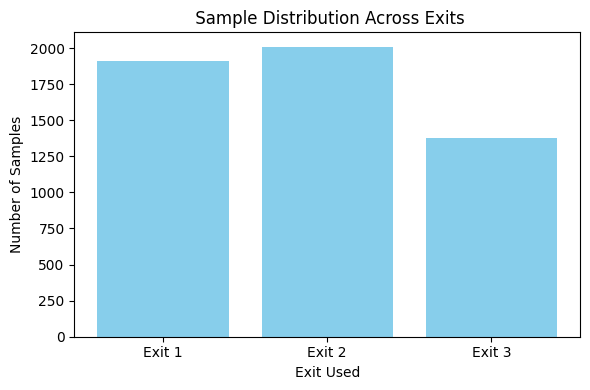


 Per-Class Accuracy:
  airplane    : 95.00% (760/800)
  automobile  : 96.75% (774/800)
  bird        : 79.88% (639/800)
  cat         : 78.50% (628/800)
  deer        : 92.17% (553/600)
  dog         : 89.50% (537/600)
  frog        : 92.50% (555/600)
  horse       : 80.00% (80/100)
  ship        : 96.00% (96/100)
  truck       : 100.00% (100/100)


In [6]:
logs = evaluate_and_log(model_with_exits, new_distribution_loader, thresholds=(0.88, 0.54))
summarize_exits(logs)
plot_exit_distribution(logs)
per_class_accuracy(logs, class_names)
exit3_ds = extract_exit_dataset(logs, exit_id=3)

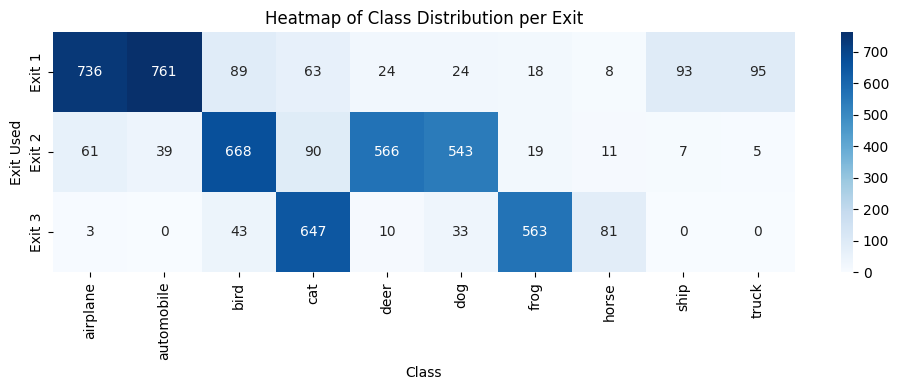


 Exit-Class 分布统计表
Class        | Exit 1   | Exit 2   | Exit 3  
---------------------------------------------
airplane     | 736     | 61      | 3      
automobile   | 761     | 39      | 0      
bird         | 89      | 668     | 43     
cat          | 63      | 90      | 647    
deer         | 24      | 566     | 10     
dog          | 24      | 543     | 33     
frog         | 18      | 19      | 563    
horse        | 8       | 11      | 81     
ship         | 93      | 7       | 0      
truck        | 95      | 5       | 0      


In [14]:
exit_class_heatmap(logs, class_names)
print_exit_byclass_table(logs, class_names)

## Pattern A

In [7]:
# Function to filter dataset by classes
def filter_by_classes(dataset, classes_to_include):
    class_indices = [dataset.class_to_idx[cls] for cls in classes_to_include]
    indices = [i for i, (_, label) in enumerate(dataset.samples) if label in class_indices]
    return Subset(dataset, indices)

In [8]:
# Define the four classes and the remaining six classes
classes_subset1a = ['airplane', 'automobile', 'bird', 'cat'] 
classes_subset1b =  ['ship', 'truck','deer', 'dog', 'frog', 'horse'] # Remaining classes 

# Create subsets for the four classes and the other six classes
subset1a = {'train':filter_by_classes(train_dataset_1, classes_subset1a),
              'test':filter_by_classes(test_dataset, classes_subset1a)}
subset1b = {'train':filter_by_classes(train_dataset_1, classes_subset1b),
            'test':filter_by_classes(test_dataset, classes_subset1b)}
# Create DataLoaders for each subset
dataloaders_subset1a = {
    'train': DataLoader(subset1a['train'], batch_size=64, shuffle=True, num_workers=4),
    'test': DataLoader(subset1a['test'], batch_size=64, shuffle=False, num_workers=4)
}
dataloaders_subset1b = {
    'train': DataLoader(subset1b['train'], batch_size=64, shuffle=True, num_workers=4),
    'test': DataLoader(subset1b['test'], batch_size=64, shuffle=False, num_workers=4)
}

In [9]:
# Define the four classes and the remaining six classes
classes_subset2a = ['airplane','automobile', 'bird','cat','deer', 'dog','frog' ]
classes_subset2b =  [ 'horse','ship', 'truck'] # Remaining classes 
# Create subsets for the four classes and the other six classes
subset2a = {'train':filter_by_classes(train_dataset_1, classes_subset2a),
              'test':filter_by_classes(test_dataset, classes_subset2a)}
subset2b = {'train':filter_by_classes(train_dataset_1, classes_subset2b),
            'test':filter_by_classes(test_dataset, classes_subset2b)}
# Create DataLoaders for each subset
dataloaders_subset2a = {
    'train': DataLoader(subset2a['train'], batch_size=64, shuffle=True, num_workers=4),
    'test': DataLoader(subset2a['test'], batch_size=64, shuffle=False, num_workers=4)
}
dataloaders_subset2b = {
    'train': DataLoader(subset2b['train'], batch_size=64, shuffle=True, num_workers=4),
    'test': DataLoader(subset2b['test'], batch_size=64, shuffle=False, num_workers=4)
}

In [10]:
# ============== 修改后的训练函数（在第二个 Cell 运行） ==============
def trainEE_KL(
    model, 
    id_dataloader, 
    id_testloader,
    ood_dataloader, 
    exit_number,
    criterion_id, 
    optimizer,
    stepsize = 30,
    num_epochs=50,
    alpha = 0.5,
    # 新增参数（无需手动传递）
    stop_event=None,     # type: threading.Event
    request_queue=None   # type: Queue
):
    if stepsize > 0:
        scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[20,40,50])
        
    for epoch in range(num_epochs):
        # 检查停止信号
        if stop_event and stop_event.is_set():
            print("\n[training has been terminated by user]")
            return
            
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        model.train()
        running_loss = 0.0
        id_corrects = 0
        ood_certainty = []

        # 混合数据批次
        data_iter = zip(id_dataloader, cycle(ood_dataloader))
        for batch_idx, ((id_inputs, id_labels), (ood_inputs, _)) in enumerate(data_iter):
            # 处理队列中的请求（每个batch处理一次）
            if request_queue and not request_queue.empty():
                while not request_queue.empty():
                    sample = request_queue.get()
                    print(f"\n[realtime request] samples siza: {sample.shape}")
                    with torch.no_grad():
                        if exit_number == 1:
                            pred, _ = model(sample.to('cuda'), return_exit1=True)
                        elif exit_number == 2:
                            pred, _ = model(sample.to('cuda'), return_exit2=True)
                        print(f"prediction: {torch.argmax(pred).item()}")

            # 原始训练逻辑
            inputs = torch.cat([id_inputs, ood_inputs], dim=0).to('cuda')
            labels = torch.cat([id_labels, torch.zeros(len(ood_inputs))], dim=0).to('cuda')
            is_id = torch.cat([torch.ones(len(id_inputs)), torch.zeros(len(ood_inputs))], dim=0).to('cuda')

            optimizer.zero_grad()

            if exit_number == 1:
                outputs, _ = model(inputs, return_exit1=True)
            elif exit_number == 2:
                outputs, _ = model(inputs, return_exit2=True)
            else:
                outputs,_ = model(inputs)

            ce_loss = criterion_id(outputs[:len(id_inputs)], labels[:len(id_inputs)].long())
            probs = F.softmax(outputs[len(id_inputs):],dim=1)
            uniform_dist = torch.ones_like(probs)/probs.size(1)
            kl_div = nn.KLDivLoss(reduction='batchmean')(F.log_softmax(outputs[len(id_inputs):], dim=1), uniform_dist)
            loss = torch.mean(is_id * ce_loss + alpha * (1 - is_id) * kl_div)    

            loss.backward()
            optimizer.step()

            # 统计信息
            running_loss += loss.item() * inputs.size(0)
            _, id_preds = torch.max(outputs[:len(id_inputs)], 1)
            id_corrects += torch.sum(id_preds == labels[:len(id_inputs)].long()).item()
            ood_certainty.append(torch.mean(F.softmax(outputs[len(id_inputs):], dim=1).max(dim=1).values).item())

        epoch_loss = running_loss / (len(id_dataloader.dataset) + len(ood_dataloader.dataset))
        epoch_id_acc = id_corrects / len(id_dataloader.dataset)
        avg_ood_certainty = sum(ood_certainty) / len(ood_certainty)
        
        print(f'Train Loss: {epoch_loss:.4f} | ID Acc: {epoch_id_acc:.4f} | OOD Certainty: {avg_ood_certainty:.4f}')
        if stepsize> 0: 
            scheduler.step()

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from itertools import cycle
import threading
from queue import Queue
# === 多线程训练控制器封装 ===
class TrainingController:
    def __init__(self):
        self.stop_event = threading.Event()
        self.request_queue = Queue()
        self.train_thread = None

    def start_training(self, train_function, **kwargs):
        """启动训练线程"""
        def _wrapper():
            train_function(
                stop_event=self.stop_event,
                request_queue=self.request_queue,
                **kwargs
            )
        self.stop_event.clear()
        self.train_thread = threading.Thread(target=_wrapper)
        self.train_thread.start()

    def add_request(self, data):
        """添加实时推理请求（暂不用于 A 模式）"""
        self.request_queue.put(data)

    def stop_training(self):
        """停止训练线程"""
        self.stop_event.set()
        if self.train_thread:
            self.train_thread.join()

# === 创建两个控制器实例 ===
controller1 = TrainingController()  # 控制 Exit1 的训练
controller2 = TrainingController()  # 控制 Exit2 的训练

In [12]:
def analyze_exit_logs_with_accuracy(all_logs, class_names):
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    df = pd.DataFrame(all_logs)

    # ===== 1. 每个出口的总体准确率 =====
    acc_stats = df.groupby('exit').apply(
        lambda g: pd.Series({
            'correct': (g['true'] == g['pred']).sum(),
            'total': len(g),
            'accuracy': (g['true'] == g['pred']).mean()
        })
    )

    print("\n📊 每个出口的总体准确率：")
    print(acc_stats[['correct', 'total', 'accuracy']])

    # ===== 2. 每个出口、每个类别的准确率 =====
    print("\n📚 每个出口的每类准确率（按 true 标签统计）：")
    grouped = df.groupby(['exit', 'true'])

    per_class_acc = {}
    for (exit_num, cls_id), group in grouped:
        correct = (group['pred'] == group['true']).sum()
        total = len(group)
        acc = correct / total if total > 0 else 0.0
        per_class_acc.setdefault(exit_num, {})[class_names[cls_id]] = acc

    # 打印每个出口的 per-class 准确率
    for exit_num in sorted(per_class_acc.keys()):
        print(f"\n📌 Exit {exit_num}：")
        for cls in class_names:
            acc = per_class_acc[exit_num].get(cls, 0.0)
            print(f"  {cls:<12}: {acc:.2%}")

    # ===== 3. 每个出口的预测类别分布（用于可视化） =====
    exit_class_pred = pd.crosstab(df['exit'], df['pred'], rownames=['Exit'], colnames=['Predicted Class'])
    exit_class_pred.columns = [class_names[c] for c in exit_class_pred.columns]

    print("\n📈 每个出口的预测类别分布：")
    display(exit_class_pred)

    # ===== 4. 可视化：柱状图 =====
    exit_class_pred.T.plot(kind='bar', figsize=(10, 5))
    plt.title("Exit-wise Predicted Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Sample Count")
    plt.tight_layout()
    plt.show()

    # ===== 5. 可视化：热力图 =====
    plt.figure(figsize=(8, 4))
    sns.heatmap(exit_class_pred, annot=True, fmt='d', cmap='YlGnBu')
    plt.title("Exit-Class Prediction Heatmap")
    plt.ylabel("Exit")
    plt.xlabel("Class")
    plt.tight_layout()
    plt.show()


In [24]:
class Timer:
    def __init__(self, name="Timer"):
        self.name = name
        self.start_time = None

    def start(self):
        self.start_time = time.time()

    def stop(self):
        if self.start_time is None:
            print(f"{self.name} 未开始计时！")
            return
        self.duration = time.time() - self.start_time
        print(f"[{self.name}] 耗时: {self.duration:.2f} 秒\n")
        return self.duration
    def elapsed(self):
        return round(self.duration, 2)

In [25]:
def run_full_suspension_parallel_realtime_logging(
    model,
    controller1, controller2,
    inference_loader,
    dataloaders_subset1a, dataloaders_subset1b,
    dataloaders_subset2a, dataloaders_subset2b,
    device='cuda'
):
    import time, psutil
    from collections import defaultdict, Counter
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import torch.nn.functional as F

    results = {}
    process = psutil.Process()

    # === 载入模型参数并冻结主干，解冻 early exits ===
    model.load_state_dict(torch.load('model_with_exits.pth'))
    for param in model.parameters():
        param.requires_grad = False
    for param in model.early_exit1.parameters():
        param.requires_grad = True
    for param in model.early_exit2.parameters():
        param.requires_grad = True

    optimizer1 = torch.optim.Adam(model.early_exit1.parameters(), lr=0.01)
    optimizer2 = torch.optim.Adam(model.early_exit2.parameters(), lr=0.01)

    train_args1 = {
        'train_function': trainEE_KL,
        'model': model,
        'id_dataloader': dataloaders_subset1a["train"],
        'id_testloader': dataloaders_subset1a["test"],
        'ood_dataloader': dataloaders_subset1b["train"],
        'exit_number': 1,
        'criterion_id': nn.CrossEntropyLoss(),
        'optimizer': optimizer1,
        'stepsize': 30,
        'num_epochs': 5,
        'alpha': 1
    }

    train_args2 = {
        'train_function': trainEE_KL,
        'model': model,
        'id_dataloader': dataloaders_subset2a["train"],
        'id_testloader': dataloaders_subset2a["test"],
        'ood_dataloader': dataloaders_subset2b["train"],
        'exit_number': 2,
        'criterion_id': nn.CrossEntropyLoss(),
        'optimizer': optimizer2,
        'stepsize': 30,
        'num_epochs': 5,
        'alpha': 1
    }

    # === 启动两个训练线程 ===
    
    
    
    print("[A-Parallel] 启动训练线程 Exit1 和 Exit2...")
    
    
    train1_timer = Timer("训练 Exit1 耗时")
    train2_timer = Timer("训练 Exit2 耗时")
    train1_timer.start()
    train2_timer.start()
    
    controller1.start_training(train_function=train_args1.pop('train_function'), **train_args1)
    controller2.start_training(train_function=train_args2.pop('train_function'), **train_args2)

    # === 推理记录结构 ===
    exit_logs = defaultdict(list)  # exit_number -> [label]
    latency_logs = []
    all_logs = {'true': [], 'pred': [], 'exit': []}  # 记录准确率分析

    print("[A-Parallel] 开始实时推理记录（auto_select=True）...")
    start_infer_time = time.time()

    for batch in inference_loader:
        images, labels = batch[0].to(device), batch[1].to(device)
        try:
            start = time.time()
            with torch.no_grad():
                outputs, exit_idx = model(images, auto_select=True, disabled_exits=[1, 2])
            end = time.time()
            latency_logs.append(end - start)

            probs = F.softmax(outputs, dim=1)
            confs, preds = torch.max(probs, dim=1)

            for i in range(len(exit_idx)):
                exit_number = exit_idx[i].item()
                true_label = labels[i].item()
                pred_label = preds[i].item()

                exit_logs[exit_number].append(true_label)
                all_logs['true'].append(true_label)
                all_logs['pred'].append(pred_label)
                all_logs['exit'].append(exit_number)

            time.sleep(0.5)  # 推理间隔
        except Exception as e:
            print(f"[ERROR] 推理失败: {e}")

    infer_duration = time.time() - start_infer_time
    print("\n[推理完成]")

    # === 推理完成后安全终止训练线程 ===
    controller1.stop_training()
    controller2.stop_training()
    train1_timer.stop()
    train2_timer.stop()
    # === 系统资源与性能记录 ===
    mem_after = process.memory_info().rss / 1024 ** 2
    threads_after = process.num_threads()

    results["Mode"] = "Full Suspension (Realtime Logging)"
    results["Inference Duration (s)"] = round(infer_duration, 2)
    results["Exit1 Training Time (s)"] = train1_timer.elapsed()
    results["Exit2 Training Time (s)"] = train2_timer.elapsed()
    results["Avg Inference Latency (s)"] = round(np.mean(latency_logs), 4)
    results["Latency Std Dev (s)"] = round(np.std(latency_logs), 4)
    results["Threads After"] = threads_after
    results["Memory After (MB)"] = round(mem_after, 2)

    # === 可视化各出口的类别分布 ===
    
    
    print("\n[可视化] 各出口类别分布")
    _visualize_exit_distribution(exit_logs, title_suffix="(Phase 1)")
    

    # === 准确率统计分析 ===
    analyze_exit_logs_with_accuracy(all_logs, class_names)

    return results, latency_logs, exit_logs


C:\Users\Zhao\AppData\Local\Temp\ipykernel_16096\3494397636.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_with_exits.pth'))


[A-Parallel] 启动训练线程 Exit1 和 Exit2...

Epoch 1/5
----------

Epoch 1/5
----------
[A-Parallel] 开始实时推理记录（auto_select=True）...
Train Loss: 0.3266 | ID Acc: 0.8572 | OOD Certainty: 0.2564

Epoch 2/5
----------
Train Loss: 0.1234 | ID Acc: 0.9825 | OOD Certainty: 0.1274

Epoch 2/5
----------
Train Loss: 0.1959 | ID Acc: 0.9378 | OOD Certainty: 0.2407

Epoch 3/5
----------

[推理完成]
Train Loss: 0.0205 | ID Acc: 0.9955 | OOD Certainty: 0.1106

Epoch 3/5
----------
Train Loss: 0.1696 | ID Acc: 0.9499 | OOD Certainty: 0.2299

[training has been terminated by user]
Train Loss: 0.0163 | ID Acc: 0.9963 | OOD Certainty: 0.1073

[training has been terminated by user]
[训练 Exit1 耗时] 耗时: 79.03 秒

[训练 Exit2 耗时] 耗时: 79.03 秒


[可视化] 各出口类别分布


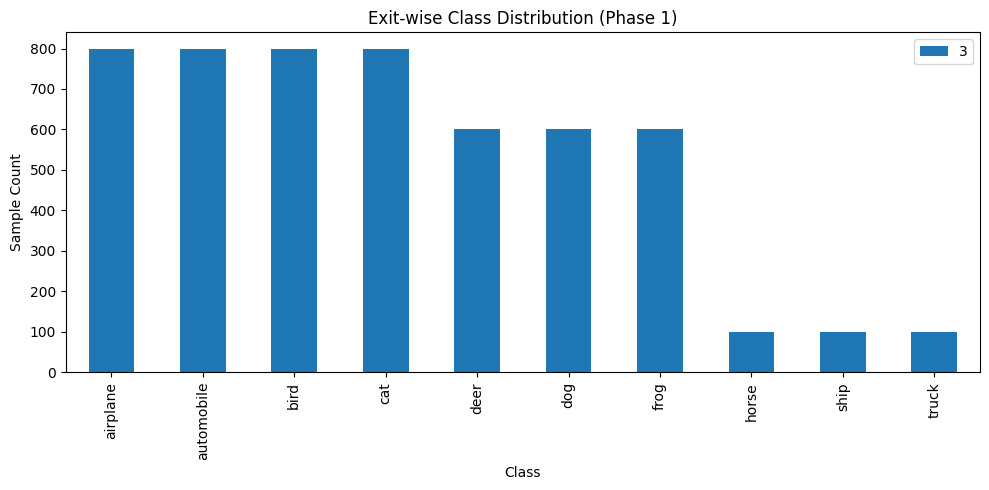

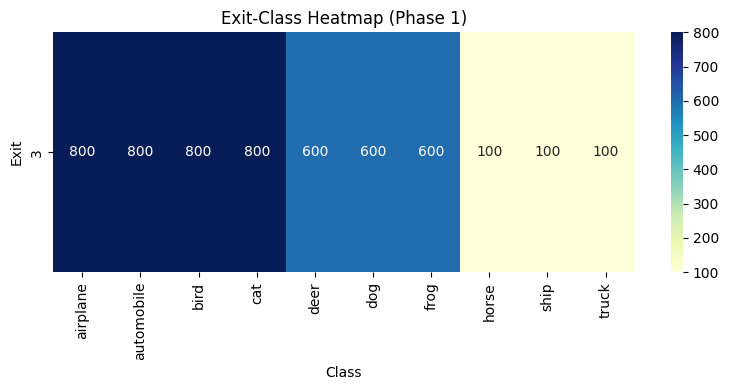


📊 每个出口的总体准确率：
      correct   total  accuracy
exit                           
3      4717.0  5300.0      0.89

📚 每个出口的每类准确率（按 true 标签统计）：

📌 Exit 3：
  airplane    : 88.75%
  automobile  : 91.50%
  bird        : 85.62%
  cat         : 82.62%
  deer        : 91.17%
  dog         : 86.83%
  frog        : 94.83%
  horse       : 96.00%
  ship        : 100.00%
  truck       : 96.00%

📈 每个出口的预测类别分布：


C:\Users\Zhao\AppData\Local\Temp\ipykernel_16096\4047240214.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_stats = df.groupby('exit').apply(


,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
Exit,,,,,,,,,,
3,736,740,710,757,599,603,603,192,189,171


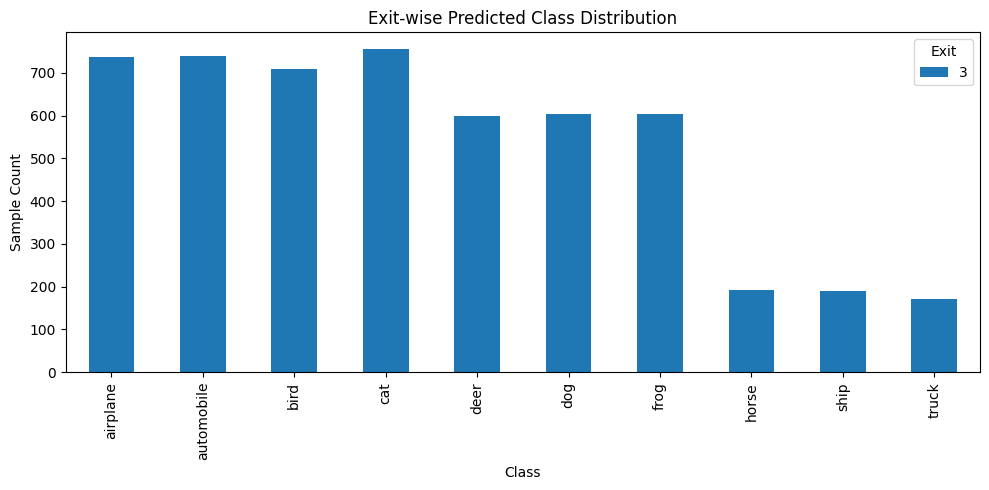

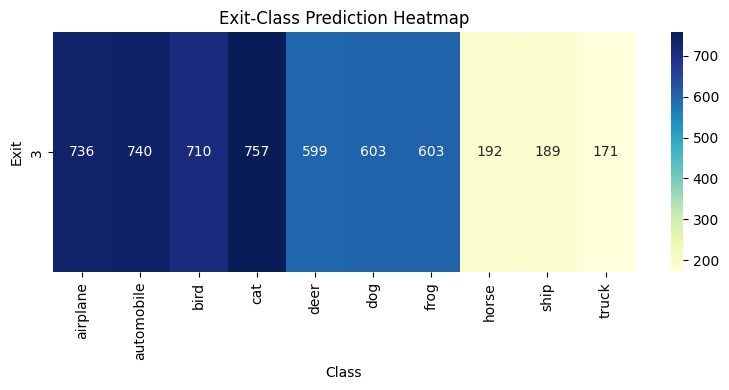

In [26]:
results, latency_logs, exit_logs = run_full_suspension_parallel_realtime_logging(
    model_with_exits,
    controller1, controller2,
    new_distribution_loader,
    dataloaders_subset1a, dataloaders_subset1b,
    dataloaders_subset2a, dataloaders_subset2b
)


In [27]:
results, latency_logs

({'Mode': 'Full Suspension (Realtime Logging)',
  'Inference Duration (s)': 53.62,
  'Exit1 Training Time (s)': 79.03,
  'Exit2 Training Time (s)': 79.03,
  'Avg Inference Latency (s)': 0.0535,
  'Latency Std Dev (s)': 0.0681,
  'Threads After': 48,
  'Memory After (MB)': 1777.47},
 [0.41231608390808105,
  0.005376577377319336,
  0.006127357482910156,
  0.01611161231994629,
  0.1241002082824707,
  0.019054889678955078,
  0.022841215133666992,
  0.02834153175354004,
  0.050492286682128906,
  0.029871463775634766,
  0.14804935455322266,
  0.05426955223083496,
  0.10752534866333008,
  0.06444382667541504,
  0.006600141525268555,
  0.04935741424560547,
  0.2183666229248047,
  0.013682365417480469,
  0.017195940017700195,
  0.24022388458251953,
  0.031133174896240234,
  0.02936577796936035,
  0.029782772064208984,
  0.24005508422851562,
  0.0472722053527832,
  0.03724241256713867,
  0.04210329055786133,
  0.05758380889892578,
  0.03351283073425293,
  0.0340123176574707,
  0.0245547294616699

C:\Users\Zhao\AppData\Local\Temp\ipykernel_16096\3494397636.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_with_exits.pth'))


[A-Parallel] 启动训练线程 Exit1 和 Exit2...

Epoch 1/5
----------

Epoch 1/5
----------
[A-Parallel] 开始实时推理记录（auto_select=True）...
Train Loss: 0.3233 | ID Acc: 0.8573 | OOD Certainty: 0.2571

Epoch 2/5
----------
Train Loss: 0.1185 | ID Acc: 0.9857 | OOD Certainty: 0.1258

Epoch 2/5
----------
Train Loss: 0.1983 | ID Acc: 0.9374 | OOD Certainty: 0.2417

Epoch 3/5
----------
Train Loss: 0.0213 | ID Acc: 0.9951 | OOD Certainty: 0.1099

Epoch 3/5
----------
Train Loss: 0.1712 | ID Acc: 0.9487 | OOD Certainty: 0.2308

Epoch 4/5
----------
Train Loss: 0.0161 | ID Acc: 0.9957 | OOD Certainty: 0.1076

Epoch 4/5
----------
Train Loss: 0.1530 | ID Acc: 0.9544 | OOD Certainty: 0.2204

Epoch 5/5
----------
Train Loss: 0.0155 | ID Acc: 0.9957 | OOD Certainty: 0.1069

Epoch 5/5
----------

[推理完成]
Train Loss: 0.1400 | ID Acc: 0.9633 | OOD Certainty: 0.2145
Train Loss: 0.0159 | ID Acc: 0.9965 | OOD Certainty: 0.1067
[训练 Exit1 耗时] 耗时: 127.23 秒

[训练 Exit2 耗时] 耗时: 127.23 秒


[可视化] 各出口类别分布


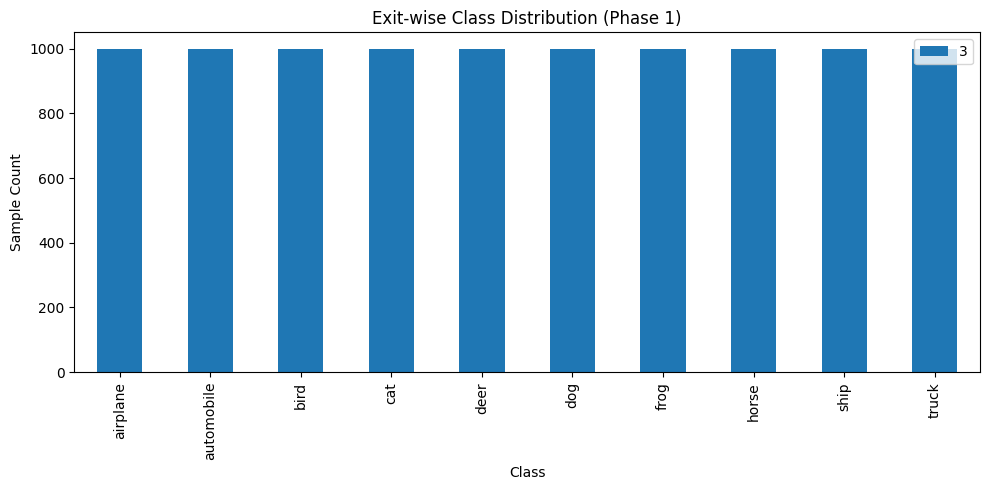

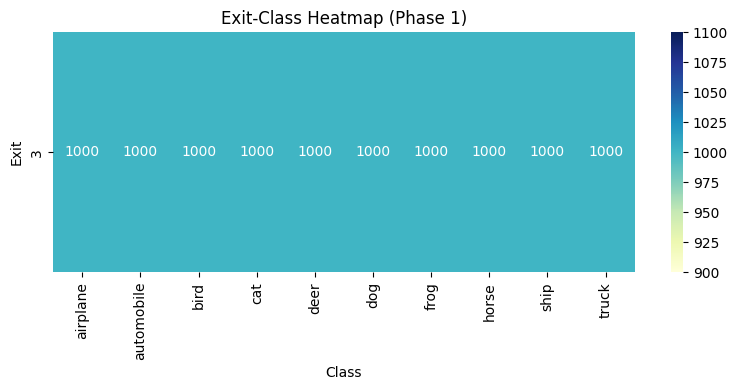


📊 每个出口的总体准确率：
      correct    total  accuracy
exit                            
3      9289.0  10000.0    0.9289

📚 每个出口的每类准确率（按 true 标签统计）：

📌 Exit 3：
  airplane    : 92.90%
  automobile  : 95.10%
  bird        : 89.80%
  cat         : 87.20%
  deer        : 93.80%
  dog         : 89.50%
  frog        : 95.50%
  horse       : 95.90%
  ship        : 96.30%
  truck       : 92.90%

📈 每个出口的预测类别分布：


C:\Users\Zhao\AppData\Local\Temp\ipykernel_16096\4047240214.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_stats = df.groupby('exit').apply(


,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
Exit,,,,,,,,,,
3,1008,980,970,1028,997,993,1002,1019,1022,981


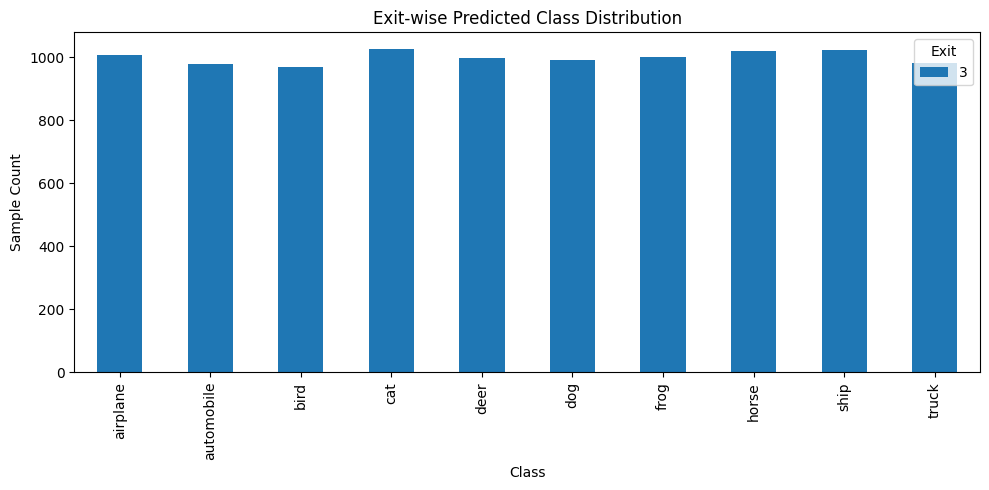

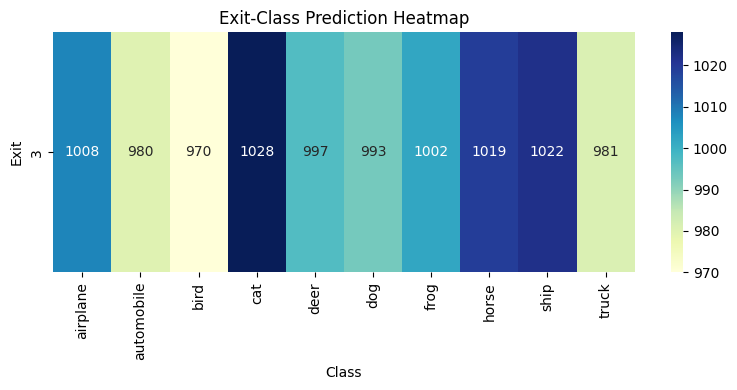

In [33]:
results, latency_logs, exit_logs = run_full_suspension_parallel_realtime_logging(
    model_with_exits,
    controller1, controller2,
    test_loader,
    dataloaders_subset1a, dataloaders_subset1b,
    dataloaders_subset2a, dataloaders_subset2b
)

In [34]:
results

{'Mode': 'Full Suspension (Realtime Logging)',
 'Inference Duration (s)': 103.88,
 'Exit1 Training Time (s)': 127.23,
 'Exit2 Training Time (s)': 127.23,
 'Avg Inference Latency (s)': 0.0525,
 'Latency Std Dev (s)': 0.0621,
 'Threads After': 48,
 'Memory After (MB)': 803.66}

## Pattern B


In [52]:
import time
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
import torch.nn as nn
import threading
import psutil


def _visualize_exit_distribution(log_dict, title_suffix=""):
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']
    exit_class_dist = pd.DataFrame.from_dict(
        {k: Counter(v) for k, v in log_dict.items()},
        orient='index'
    ).fillna(0).astype(int)

    for i in range(len(class_names)):
        if i not in exit_class_dist.columns:
            exit_class_dist[i] = 0
    exit_class_dist = exit_class_dist[sorted(exit_class_dist.columns)]
    exit_class_dist.columns = class_names

    exit_class_dist.T.plot(kind='bar', figsize=(10, 5))
    plt.title(f"Exit-wise Class Distribution {title_suffix}")
    plt.xlabel("Class")
    plt.ylabel("Sample Count")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    sns.heatmap(exit_class_dist, annot=True, fmt='d', cmap='YlGnBu')
    plt.title(f"Exit-Class Heatmap {title_suffix}")
    plt.ylabel("Exit")
    plt.xlabel("Class")
    plt.tight_layout()
    plt.show()

def run_patternB_execution(
    model,
    controller1, controller2,
    inference_loader,
    dataloaders_subset1a, dataloaders_subset1b,
    dataloaders_subset2a, dataloaders_subset2b,
    device='cuda'
):
    results = {}
    exit_logs = defaultdict(list)
    all_logs = {'true': [], 'pred': [], 'exit': []}
    latency_logs = []
    inference_logs_phase1 = defaultdict(list)
    inference_logs_phase2 = defaultdict(list)

    process = psutil.Process()
    model.load_state_dict(torch.load('model_with_exits.pth'))

    current_exit_mode = {'mode': 'exit1_train'}
    stop_flag = {'stop': False}
    switch_requested = {'flag': False}

    def inference_thread():
        print("[PatternB] 启动推理线程...")
        start_infer_time = time.time()

        for batch in inference_loader:
            if switch_requested['flag']:
                print("[PatternB] 检测到模式切换请求，完成当前 batch 后切换...")
                current_exit_mode['mode'] = 'exit2_train'
                switch_requested['flag'] = False

            images, labels = batch[0].to(device), batch[1].to(device)
            try:
                if current_exit_mode['mode'] == 'exit2_train':
                    disabled_exits = [1]
                elif current_exit_mode['mode'] == 'exit1_train':
                    disabled_exits = [2]
                else:
                    disabled_exits = []

                start = time.time()
                with torch.no_grad():
                    outputs, exit_idx = model(images, auto_select=True, disabled_exits=disabled_exits)
                end = time.time()
                latency_logs.append(end - start)

                probs = F.softmax(outputs, dim=1)
                confs, preds = torch.max(probs, dim=1)

                for i in range(len(exit_idx)):
                    exit_number = exit_idx[i].item()
                    true_label = labels[i].item()
                    pred_label = preds[i].item()

                    exit_logs[exit_number].append(true_label)
                    all_logs['true'].append(true_label)
                    all_logs['pred'].append(pred_label)
                    all_logs['exit'].append(exit_number)

                    if current_exit_mode['mode'] == 'exit1_train':
                        inference_logs_phase1[exit_number].append(true_label)
                    else:
                        inference_logs_phase2[exit_number].append(true_label)

                time.sleep(1.5)

            except Exception as e:
                print(f"[ERROR] 推理失败: {e}")

            if stop_flag['stop']:
                break

        results["Inference Duration (s)"] = round(time.time() - start_infer_time, 2)
        print("[PatternB] 推理线程结束")

    infer_thread = threading.Thread(target=inference_thread)
    infer_thread.start()

    # 第一阶段训练 Exit1
    for param in model.parameters():
        param.requires_grad = False
    for param in model.early_exit1.parameters():
        param.requires_grad = True

    optimizer1 = torch.optim.Adam(model.early_exit1.parameters(), lr=0.01)
    train_args1 = {
        'train_function': trainEE_KL,
        'model': model,
        'id_dataloader': dataloaders_subset1a["train"],
        'id_testloader': dataloaders_subset1a["test"],
        'ood_dataloader': dataloaders_subset1b["train"],
        'exit_number': 1,
        'criterion_id': nn.CrossEntropyLoss(),
        'optimizer': optimizer1,
        'stepsize': 30,
        'num_epochs': 5,
        'alpha': 1
    }
    print("[PatternB] 第一阶段：训练 Exit1 (Exit2 和主干处理推理)...")
    train1_timer = Timer("训练 Exit1 耗时")
    train1_timer.start()
    controller1.start_training(train_function=train_args1.pop('train_function'), **train_args1)
    controller1.train_thread.join()
    train1_timer.stop()

    # 第二阶段训练 Exit2
    switch_requested['flag'] = True
    for param in model.early_exit1.parameters():
        param.requires_grad = False
    for param in model.early_exit2.parameters():
        param.requires_grad = True

    optimizer2 = torch.optim.Adam(model.early_exit2.parameters(), lr=0.01)
    train_args2 = {
        'train_function': trainEE_KL,
        'model': model,
        'id_dataloader': dataloaders_subset2a["train"],
        'id_testloader': dataloaders_subset2a["test"],
        'ood_dataloader': dataloaders_subset2b["train"],
        'exit_number': 2,
        'criterion_id': nn.CrossEntropyLoss(),
        'optimizer': optimizer2,
        'stepsize': 30,
        'num_epochs': 5,
        'alpha': 1
    }
    print("[PatternB] 第二阶段：训练 Exit2 (Exit1 和主干处理推理)...")
    train2_timer = Timer("训练 Exit2 耗时")
    train2_timer.start()
    controller2.start_training(train_function=train_args2.pop('train_function'), **train_args2)
    controller2.train_thread.join()
    train2_timer.stop()

    stop_flag['stop'] = True
    infer_thread.join()

    print("\n[可视化] 第一阶段各出口类别分布")
    _visualize_exit_distribution(inference_logs_phase1, title_suffix="(Phase 1)")
    print("\n[可视化] 第二阶段各出口类别分布")
    _visualize_exit_distribution(inference_logs_phase2, title_suffix="(Phase 2)")

    results["模式"] = "PatternB 顺序切换"
    results["平均推理延迟 (s)"] = round(np.mean(latency_logs), 4)
    results["延迟标准差 (s)"] = round(np.std(latency_logs), 4)
    results["内存占用 (MB)"] = round(process.memory_info().rss / 1024 ** 2, 2)
    results["线程数"] = process.num_threads()

    print("\n[可视化] 合并的出口类别分布")
    _visualize_exit_distribution(exit_logs, title_suffix="(Combined)")

    analyze_exit_logs_with_accuracy(all_logs, [
        'airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck'
    ])

    return results, latency_logs, exit_logs


C:\Users\Zhao\AppData\Local\Temp\ipykernel_16096\649332702.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_with_exits.pth'))


[PatternB] 启动推理线程...[PatternB] 第一阶段：训练 Exit1 (Exit2 和主干处理推理)...


Epoch 1/5
----------
Train Loss: 0.3245 | ID Acc: 0.8531 | OOD Certainty: 0.2573

Epoch 2/5
----------
Train Loss: 0.2002 | ID Acc: 0.9386 | OOD Certainty: 0.2418

Epoch 3/5
----------
Train Loss: 0.1680 | ID Acc: 0.9495 | OOD Certainty: 0.2272

Epoch 4/5
----------
Train Loss: 0.1516 | ID Acc: 0.9560 | OOD Certainty: 0.2194

Epoch 5/5
----------
Train Loss: 0.1393 | ID Acc: 0.9609 | OOD Certainty: 0.2117
[训练 Exit1 耗时] 耗时: 109.99 秒

[PatternB] 第二阶段：训练 Exit2 (Exit1 和主干处理推理)...

Epoch 1/5
----------
[PatternB] 检测到模式切换请求，完成当前 batch 后切换...
Train Loss: 0.1263 | ID Acc: 0.9823 | OOD Certainty: 0.1282

Epoch 2/5
----------
[PatternB] 推理线程结束
Train Loss: 0.0220 | ID Acc: 0.9949 | OOD Certainty: 0.1098

Epoch 3/5
----------
Train Loss: 0.0190 | ID Acc: 0.9955 | OOD Certainty: 0.1078

Epoch 4/5
----------
Train Loss: 0.0175 | ID Acc: 0.9953 | OOD Certainty: 0.1081

Epoch 5/5
----------
Train Loss: 0.0106 | ID Acc: 0.9971 | OOD Cert

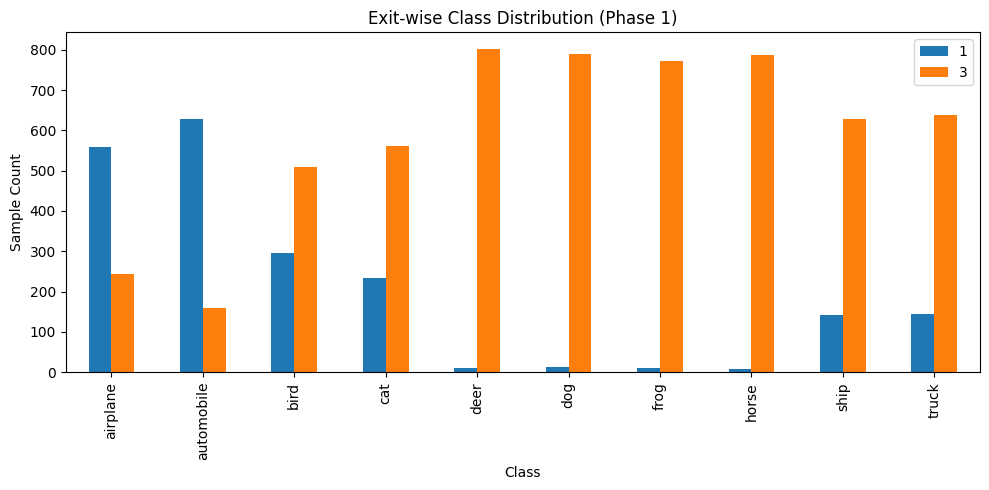

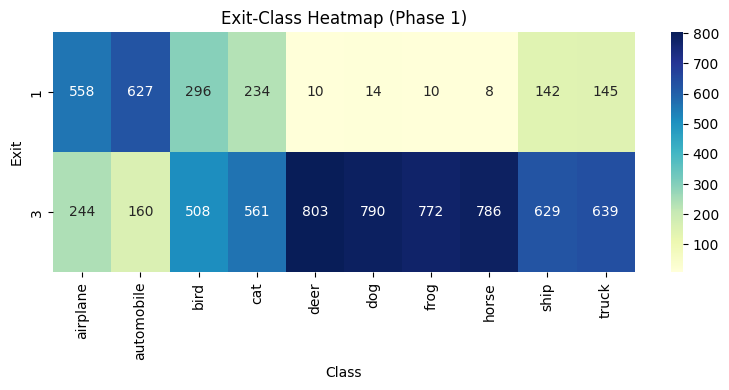


[可视化] 第二阶段各出口类别分布


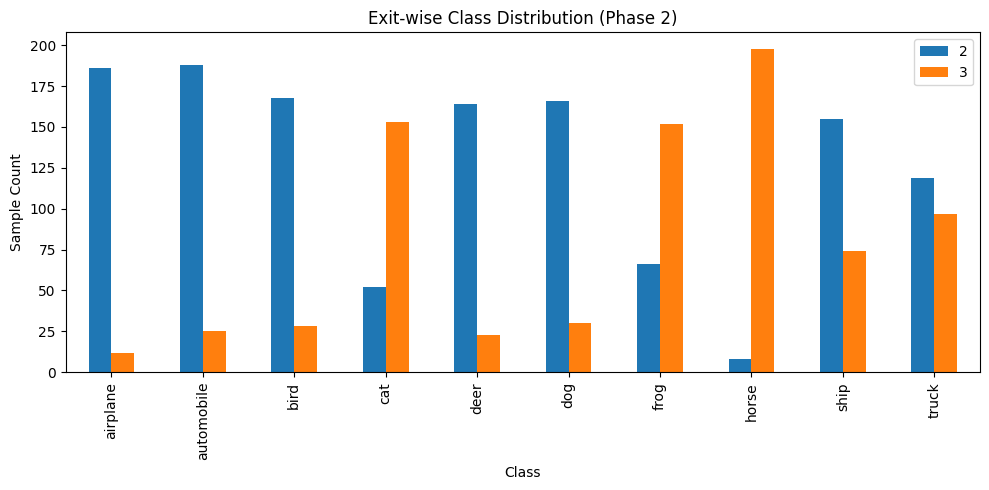

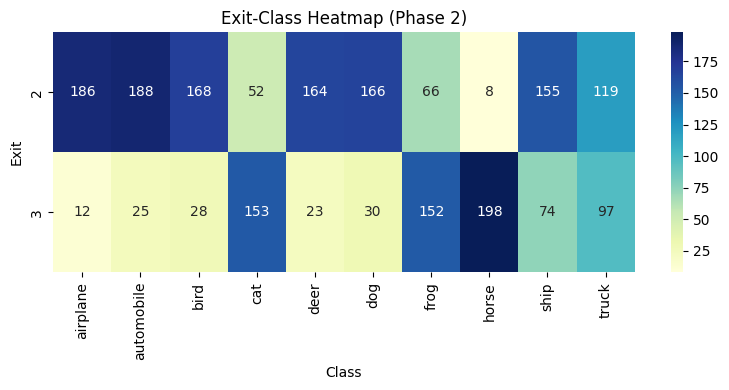


[可视化] 合并的出口类别分布


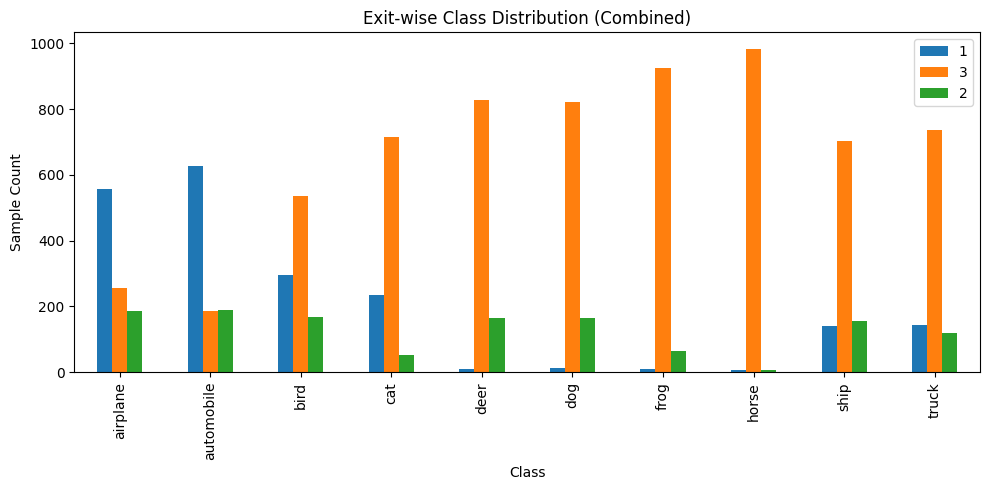

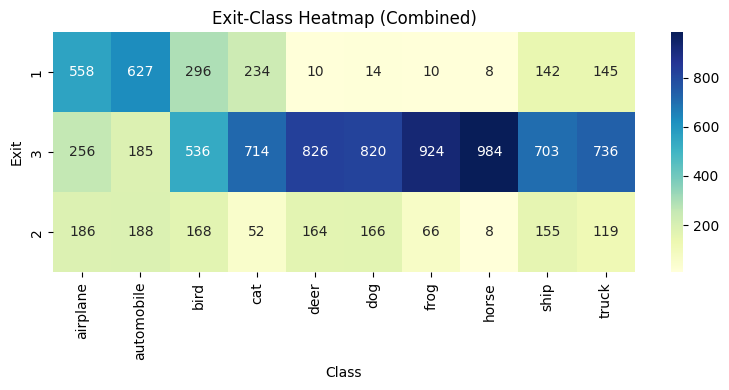


📊 每个出口的总体准确率：
      correct   total  accuracy
exit                           
1      1915.0  2044.0  0.936888
2      1187.0  1272.0  0.933176
3      6076.0  6684.0  0.909037

📚 每个出口的每类准确率（按 true 标签统计）：

📌 Exit 1：
  airplane    : 97.67%
  automobile  : 99.52%
  bird        : 91.89%
  cat         : 96.15%
  deer        : 0.00%
  dog         : 0.00%
  frog        : 0.00%
  horse       : 0.00%
  ship        : 88.03%
  truck       : 85.52%

📌 Exit 2：
  airplane    : 95.70%
  automobile  : 97.34%
  bird        : 88.69%
  cat         : 71.15%
  deer        : 95.73%
  dog         : 96.39%
  frog        : 89.39%
  horse       : 0.00%
  ship        : 96.13%
  truck       : 96.64%

📌 Exit 3：
  airplane    : 80.08%
  automobile  : 78.92%
  bird        : 83.77%
  cat         : 84.03%
  deer        : 93.10%
  dog         : 88.41%
  frog        : 95.89%
  horse       : 96.34%
  ship        : 96.16%
  truck       : 91.30%

📈 每个出口的预测类别分布：


C:\Users\Zhao\AppData\Local\Temp\ipykernel_16096\4047240214.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_stats = df.groupby('exit').apply(


,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
Exit,,,,,,,,,,
1,601,651,282,244,0,0,0,0,133,133
2,198,185,156,47,171,176,66,0,153,120
3,261,170,512,744,814,812,927,1008,723,713


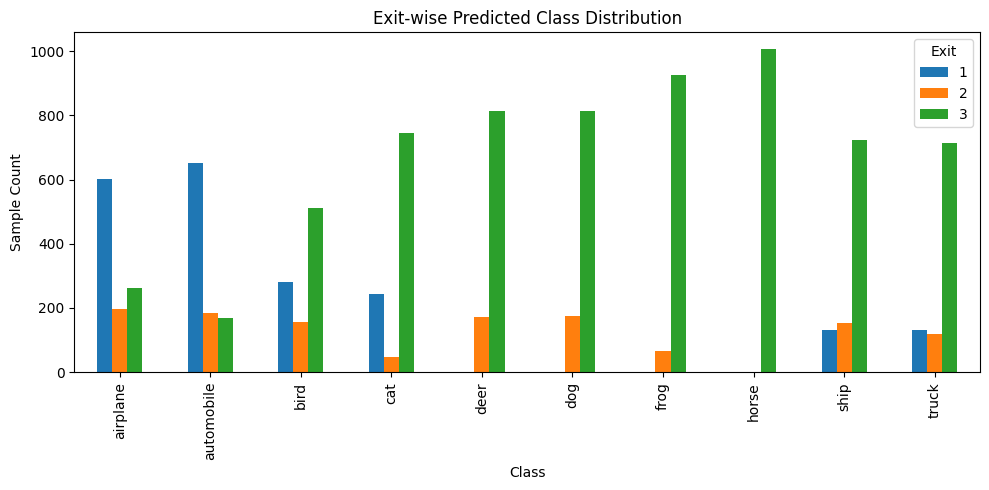

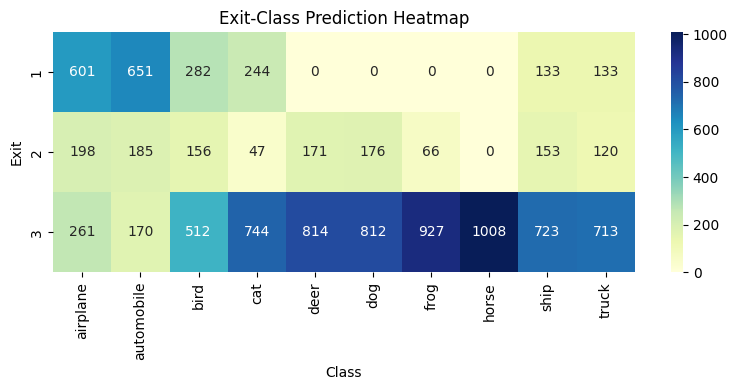

In [48]:
results, latency_logs, exit_logs = run_patternB_execution(
    model_with_exits,
    controller1, controller2,
    test_loader,
    dataloaders_subset1a, dataloaders_subset1b,
    dataloaders_subset2a, dataloaders_subset2b
)

In [49]:
results

{'Inference Duration (s)': 140.06,
 '模式': 'PatternB 顺序切换',
 '平均推理延迟 (s)': 0.0367,
 '延迟标准差 (s)': 0.0366,
 '内存占用 (MB)': 810.25,
 '线程数': 48}

C:\Users\Zhao\AppData\Local\Temp\ipykernel_16096\713378291.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_with_exits.pth'))


[PatternB] 启动推理线程...[PatternB] 第一阶段：训练 Exit1 (Exit2 和主干处理推理)...


Epoch 1/5
----------
Train Loss: 0.3306 | ID Acc: 0.8564 | OOD Certainty: 0.2587

Epoch 2/5
----------
Train Loss: 0.1964 | ID Acc: 0.9379 | OOD Certainty: 0.2416

Epoch 3/5
----------
Train Loss: 0.1683 | ID Acc: 0.9506 | OOD Certainty: 0.2273

Epoch 4/5
----------
Train Loss: 0.1522 | ID Acc: 0.9535 | OOD Certainty: 0.2186

Epoch 5/5
----------
Train Loss: 0.1367 | ID Acc: 0.9619 | OOD Certainty: 0.2132
[训练 Exit1 耗时] 耗时: 110.98 秒

[PatternB] 第二阶段：训练 Exit2 (Exit1 和主干处理推理)...

Epoch 1/5
----------
[PatternB] 检测到模式切换请求，完成当前 batch 后切换...
[PatternB] 推理线程结束
Train Loss: 0.1284 | ID Acc: 0.9844 | OOD Certainty: 0.1282

Epoch 2/5
----------
Train Loss: 0.0208 | ID Acc: 0.9957 | OOD Certainty: 0.1096

Epoch 3/5
----------
Train Loss: 0.0157 | ID Acc: 0.9968 | OOD Certainty: 0.1076

Epoch 4/5
----------
Train Loss: 0.0184 | ID Acc: 0.9951 | OOD Certainty: 0.1082

Epoch 5/5
----------
Train Loss: 0.0136 | ID Acc: 0.9969 | OOD Cert

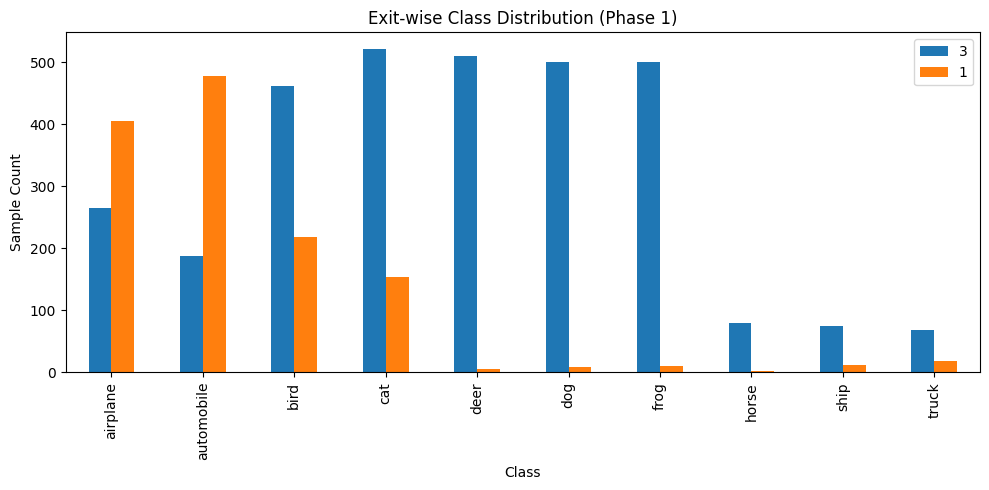

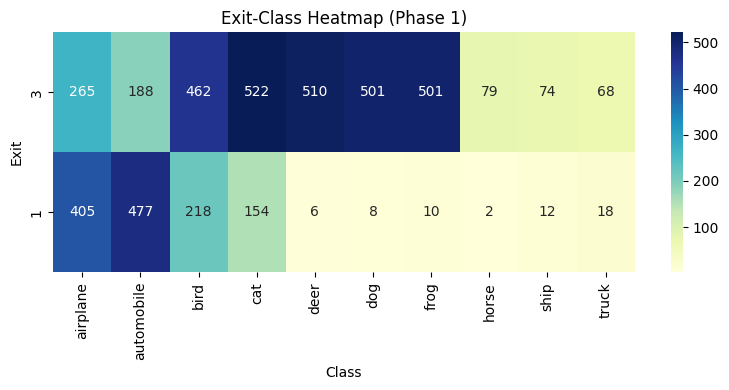


[可视化] 第二阶段各出口类别分布


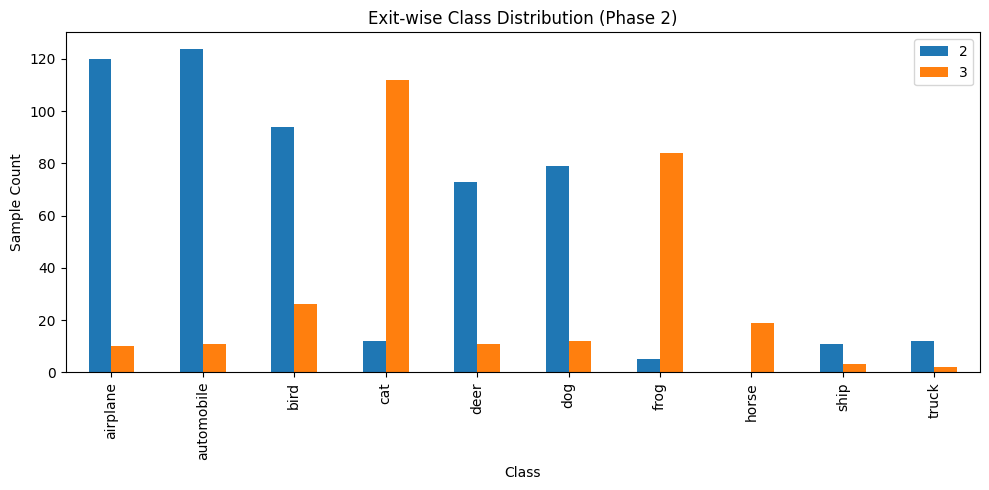

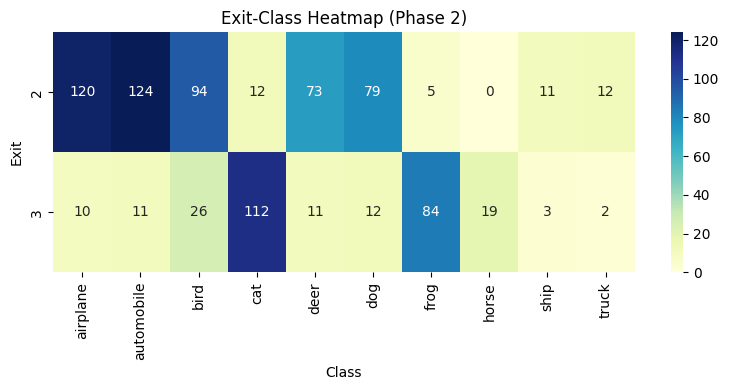


[可视化] 合并的出口类别分布


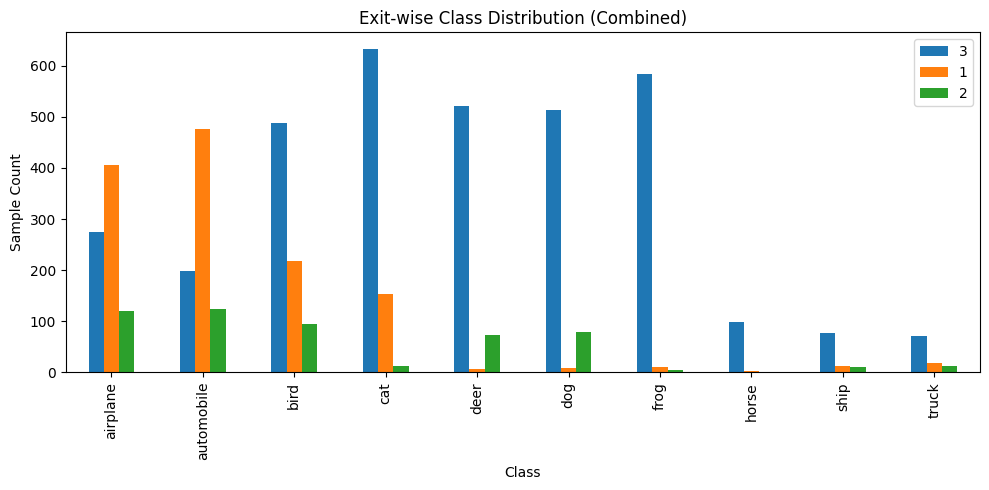

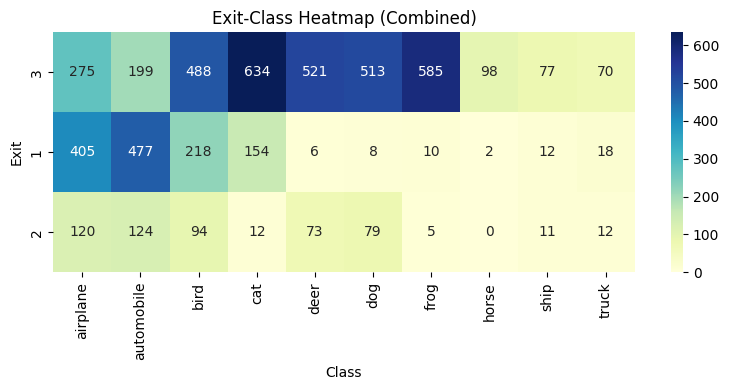


📊 每个出口的总体准确率：
      correct   total  accuracy
exit                           
1      1230.0  1310.0  0.938931
2       493.0   530.0  0.930189
3      2955.0  3460.0  0.854046

📚 每个出口的每类准确率（按 true 标签统计）：

📌 Exit 1：
  airplane    : 94.81%
  automobile  : 98.53%
  bird        : 92.20%
  cat         : 95.45%
  deer        : 0.00%
  dog         : 0.00%
  frog        : 0.00%
  horse       : 0.00%
  ship        : 91.67%
  truck       : 94.44%

📌 Exit 2：
  airplane    : 92.50%
  automobile  : 94.35%
  bird        : 92.55%
  cat         : 41.67%
  deer        : 94.52%
  dog         : 98.73%
  frog        : 80.00%
  horse       : 0.00%
  ship        : 100.00%
  truck       : 91.67%

📌 Exit 3：
  airplane    : 75.64%
  automobile  : 73.37%
  bird        : 78.89%
  cat         : 79.81%
  deer        : 91.36%
  dog         : 86.16%
  frog        : 94.53%
  horse       : 96.94%
  ship        : 100.00%
  truck       : 95.71%

📈 每个出口的预测类别分布：


C:\Users\Zhao\AppData\Local\Temp\ipykernel_16096\4047240214.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_stats = df.groupby('exit').apply(


,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
Exit,,,,,,,,,,
1,400,479,211,152,0,0,0,0,29,39
2,115,118,91,5,73,87,4,0,18,19
3,222,153,405,585,524,520,583,189,146,133


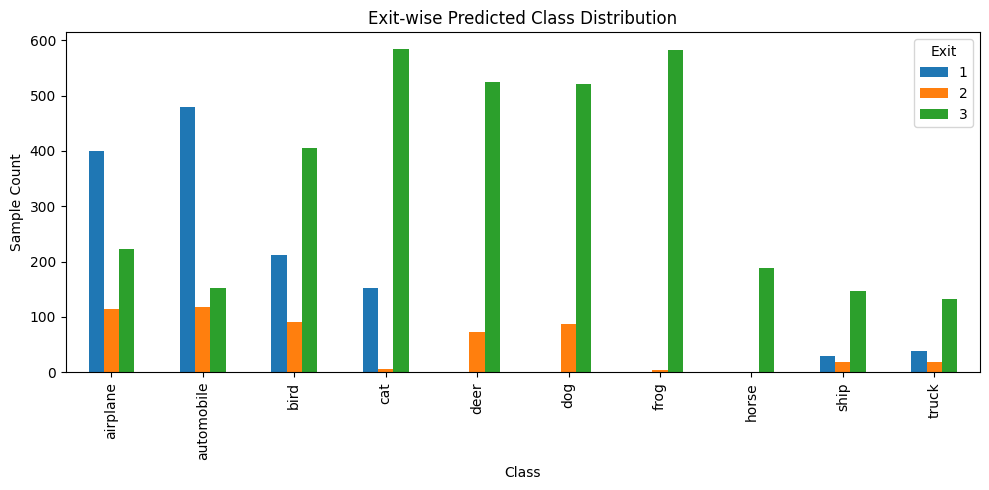

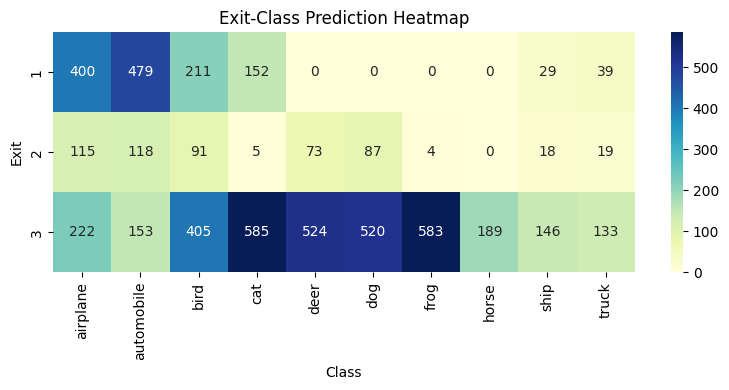

In [53]:
results, latency_logs, exit_logs = run_patternB_execution(
    model_with_exits,
    controller1, controller2,
    new_distribution_loader,
    dataloaders_subset1a, dataloaders_subset1b,
    dataloaders_subset2a, dataloaders_subset2b
)

In [54]:
results

{'Inference Duration (s)': 132.67,
 '模式': 'PatternB 顺序切换',
 '平均推理延迟 (s)': 0.056,
 '延迟标准差 (s)': 0.078,
 '内存占用 (MB)': 806.97,
 '线程数': 47}

## Pattern C

In [28]:
def run_shared_parallel_execution(
    model,
    controller1, controller2,
    inference_loader,
    dataloaders_subset1a, dataloaders_subset1b,
    dataloaders_subset2a, dataloaders_subset2b,
    device='cuda'
):
    import time, psutil
    from collections import defaultdict, Counter
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import torch.nn.functional as F

    results = {}
    process = psutil.Process()

    # === 加载模型并设置参数 ===
    model.load_state_dict(torch.load('model_with_exits.pth'))
    for param in model.parameters():
        param.requires_grad = False
    for param in model.early_exit1.parameters():
        param.requires_grad = True
    for param in model.early_exit2.parameters():
        param.requires_grad = True

    optimizer1 = torch.optim.Adam(model.early_exit1.parameters(), lr=0.01)
    optimizer2 = torch.optim.Adam(model.early_exit2.parameters(), lr=0.01)

    train_args1 = {
        'train_function': trainEE_KL,
        'model': model,
        'id_dataloader': dataloaders_subset1a["train"],
        'id_testloader': dataloaders_subset1a["test"],
        'ood_dataloader': dataloaders_subset1b["train"],
        'exit_number': 1,
        'criterion_id': nn.CrossEntropyLoss(),
        'optimizer': optimizer1,
        'stepsize': 30,
        'num_epochs': 5,
        'alpha': 1
    }

    train_args2 = {
        'train_function': trainEE_KL,
        'model': model,
        'id_dataloader': dataloaders_subset2a["train"],
        'id_testloader': dataloaders_subset2a["test"],
        'ood_dataloader': dataloaders_subset2b["train"],
        'exit_number': 2,
        'criterion_id': nn.CrossEntropyLoss(),
        'optimizer': optimizer2,
        'stepsize': 30,
        'num_epochs': 5,
        'alpha': 1
    }

    print("[C-Shared] 启动训练线程 Exit1 和 Exit2...")
    train1_timer = Timer("训练 Exit1 耗时")
    train2_timer = Timer("训练 Exit2 耗时")
    train1_timer.start()
    train2_timer.start()
    controller1.start_training(train_function=train_args1.pop('train_function'), **train_args1)
    controller2.start_training(train_function=train_args2.pop('train_function'), **train_args2)

    # === 推理记录结构 ===
    exit_logs = defaultdict(list)
    latency_logs = []
    all_logs = {'true': [], 'pred': [], 'exit': []}

    print("[C-Shared] 开始共享模型实时推理记录（auto_select=True）...")
    start_infer_time = time.time()

    for batch in inference_loader:
        images, labels = batch[0].to(device), batch[1].to(device)
        try:
            start = time.time()
            with torch.no_grad():
                outputs, exit_idx = model(images, auto_select=True)  # 所有 exits 可用
            end = time.time()
            latency_logs.append(end - start)

            probs = F.softmax(outputs, dim=1)
            confs, preds = torch.max(probs, dim=1)

            for i in range(len(exit_idx)):
                exit_number = exit_idx[i].item()
                true_label = labels[i].item()
                pred_label = preds[i].item()

                exit_logs[exit_number].append(true_label)
                all_logs['true'].append(true_label)
                all_logs['pred'].append(pred_label)
                all_logs['exit'].append(exit_number)

            time.sleep(0.5)
        except Exception as e:
            print(f"[ERROR] 推理失败: {e}")

    infer_duration = time.time() - start_infer_time
    print("\n[推理完成]")

    controller1.stop_training()
    controller2.stop_training()
    train1_timer.stop()
    train2_timer.stop()
    # === 系统资源与性能记录 ===

    results["Exit1 Training Time (s)"] = train1_timer.elapsed()
    results["Exit2 Training Time (s)"] = train2_timer.elapsed()
    mem_after = process.memory_info().rss / 1024 ** 2
    threads_after = process.num_threads()

    results["Mode"] = "Shared Parallel Execution"
    results["Inference Duration (s)"] = round(infer_duration, 2)
    results["Avg Inference Latency (s)"] = round(np.mean(latency_logs), 4)
    results["Latency Std Dev (s)"] = round(np.std(latency_logs), 4)
    results["Threads After"] = threads_after
    results["Memory After (MB)"] = round(mem_after, 2)

#     class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
#                    'dog', 'frog', 'horse', 'ship', 'truck']
#     exit_class_dist = pd.DataFrame.from_dict(
#     {k: Counter(v) for k, v in exit_logs.items()},
#     orient='index'
#     ).fillna(0).astype(int)

#     for i in range(len(class_names)):
#         if i not in exit_class_dist.columns:
#             exit_class_dist[i] = 0
#     exit_class_dist = exit_class_dist[sorted(exit_class_dist.columns)]
#     exit_class_dist.columns = class_names

#     print("\n[可视化] 各出口类别分布：")
#     exit_class_dist.T.plot(kind='bar', figsize=(10, 5))
#     plt.title("Exit-wise Class Distribution (Shared Mode)")
#     plt.xlabel("Class")
#     plt.ylabel("Sample Count")
#     plt.tight_layout()
#     plt.show()

#     plt.figure(figsize=(8, 4))
#     sns.heatmap(exit_class_dist, annot=True, fmt='d', cmap='YlGnBu')
#     plt.title("Exit-Class Heatmap (Shared Mode)")
#     plt.ylabel("Exit")
#     plt.xlabel("Class")
#     plt.tight_layout()
#     plt.show()
    print("\n[可视化] 各出口类别分布")
    _visualize_exit_distribution(exit_logs, title_suffix="(Shared Mode)")
    
    analyze_exit_logs_with_accuracy(all_logs, class_names)

    return results, latency_logs, exit_logs



C:\Users\Zhao\AppData\Local\Temp\ipykernel_16096\1272916899.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_with_exits.pth'))


[C-Shared] 启动训练线程 Exit1 和 Exit2...

Epoch 1/5
----------

Epoch 1/5
----------
[C-Shared] 开始共享模型实时推理记录（auto_select=True）...
Train Loss: 0.3127 | ID Acc: 0.8615 | OOD Certainty: 0.2561

Epoch 2/5
----------
Train Loss: 0.1240 | ID Acc: 0.9852 | OOD Certainty: 0.1272

Epoch 2/5
----------
Train Loss: 0.1964 | ID Acc: 0.9372 | OOD Certainty: 0.2402

Epoch 3/5
----------
Train Loss: 0.0252 | ID Acc: 0.9937 | OOD Certainty: 0.1105

Epoch 3/5
----------
Train Loss: 0.1716 | ID Acc: 0.9471 | OOD Certainty: 0.2277

Epoch 4/5
----------
Train Loss: 0.0158 | ID Acc: 0.9967 | OOD Certainty: 0.1078

Epoch 4/5
----------
Train Loss: 0.1531 | ID Acc: 0.9563 | OOD Certainty: 0.2192

Epoch 5/5
----------

[推理完成]
Train Loss: 0.0122 | ID Acc: 0.9967 | OOD Certainty: 0.1060

Epoch 5/5
----------
Train Loss: 0.1361 | ID Acc: 0.9626 | OOD Certainty: 0.2123
Train Loss: 0.0170 | ID Acc: 0.9955 | OOD Certainty: 0.1073
[训练 Exit1 耗时] 耗时: 128.72 秒

[训练 Exit2 耗时] 耗时: 128.72 秒


[可视化] 各出口类别分布


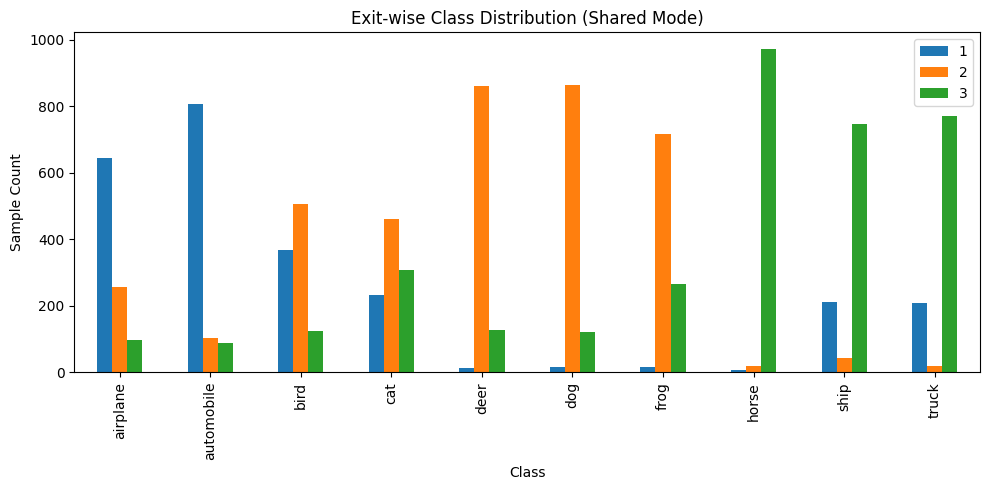

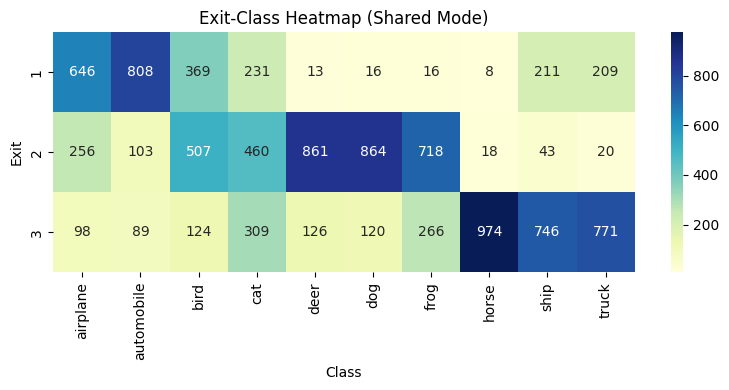


📊 每个出口的总体准确率：
      correct   total  accuracy
exit                           
1      2346.0  2527.0  0.928374
2      3527.0  3850.0  0.916104
3      3243.0  3623.0  0.895115

📚 每个出口的每类准确率（按 true 标签统计）：

📌 Exit 1：
  airplane    : 97.06%
  automobile  : 99.50%
  bird        : 93.77%
  cat         : 94.37%
  deer        : 0.00%
  dog         : 0.00%
  frog        : 0.00%
  horse       : 0.00%
  ship        : 82.46%
  truck       : 84.69%

📌 Exit 2：
  airplane    : 92.58%
  automobile  : 96.12%
  bird        : 88.95%
  cat         : 81.96%
  deer        : 94.31%
  dog         : 94.44%
  frog        : 96.80%
  horse       : 0.00%
  ship        : 69.77%
  truck       : 50.00%

📌 Exit 3：
  airplane    : 65.31%
  automobile  : 56.18%
  bird        : 66.13%
  cat         : 82.85%
  deer        : 70.63%
  dog         : 54.17%
  frog        : 92.48%
  horse       : 97.43%
  ship        : 97.05%
  truck       : 93.13%

📈 每个出口的预测类别分布：


C:\Users\Zhao\AppData\Local\Temp\ipykernel_16096\4047240214.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_stats = df.groupby('exit').apply(


,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
Exit,,,,,,,,,,
1,687,866,368,229,0,0,0,0,185,192
2,271,111,497,450,851,900,725,0,32,13
3,105,63,117,338,105,95,267,1004,770,759


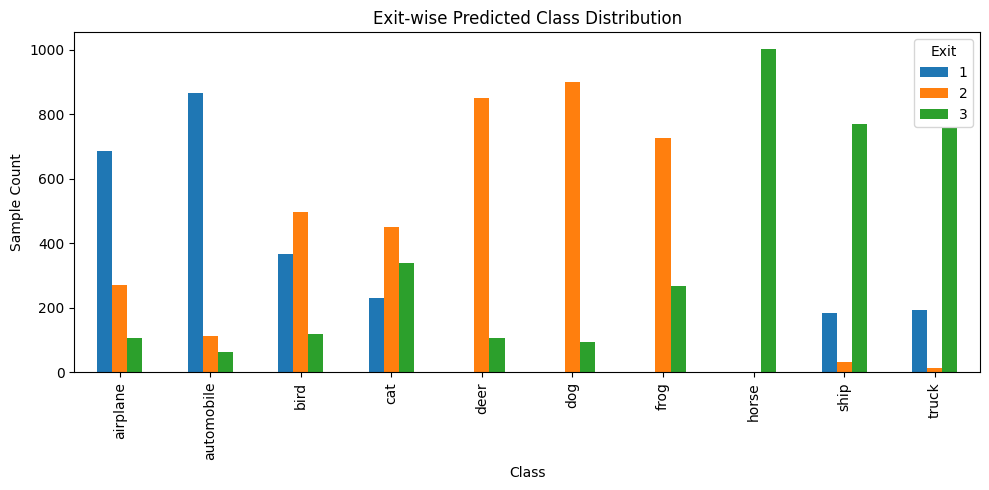

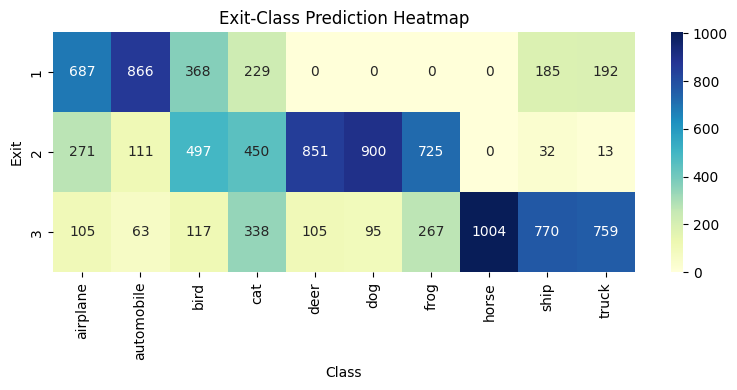

In [29]:
results, latency_logs, exit_logs = run_shared_parallel_execution(
    model_with_exits,
    controller1, controller2,
    test_loader,
    dataloaders_subset1a, dataloaders_subset1b,
    dataloaders_subset2a, dataloaders_subset2b
)

In [30]:
results

{'Exit1 Training Time (s)': 128.72,
 'Exit2 Training Time (s)': 128.72,
 'Mode': 'Shared Parallel Execution',
 'Inference Duration (s)': 101.54,
 'Avg Inference Latency (s)': 0.0511,
 'Latency Std Dev (s)': 0.0605,
 'Threads After': 48,
 'Memory After (MB)': 1782.72}

C:\Users\Zhao\AppData\Local\Temp\ipykernel_16096\1272916899.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_with_exits.pth'))


[C-Shared] 启动训练线程 Exit1 和 Exit2...

Epoch 1/5
----------

Epoch 1/5
----------
[C-Shared] 开始共享模型实时推理记录（auto_select=True）...
Train Loss: 0.3215 | ID Acc: 0.8623 | OOD Certainty: 0.2563

Epoch 2/5
----------
Train Loss: 0.1229 | ID Acc: 0.9844 | OOD Certainty: 0.1277

Epoch 2/5
----------
Train Loss: 0.1984 | ID Acc: 0.9341 | OOD Certainty: 0.2389

Epoch 3/5
----------
Train Loss: 0.0177 | ID Acc: 0.9960 | OOD Certainty: 0.1090

Epoch 3/5
----------

[推理完成]
Train Loss: 0.1707 | ID Acc: 0.9470 | OOD Certainty: 0.2274

[training has been terminated by user]
Train Loss: 0.0250 | ID Acc: 0.9931 | OOD Certainty: 0.1092

[training has been terminated by user]
[训练 Exit1 耗时] 耗时: 77.00 秒

[训练 Exit2 耗时] 耗时: 77.00 秒


[可视化] 各出口类别分布


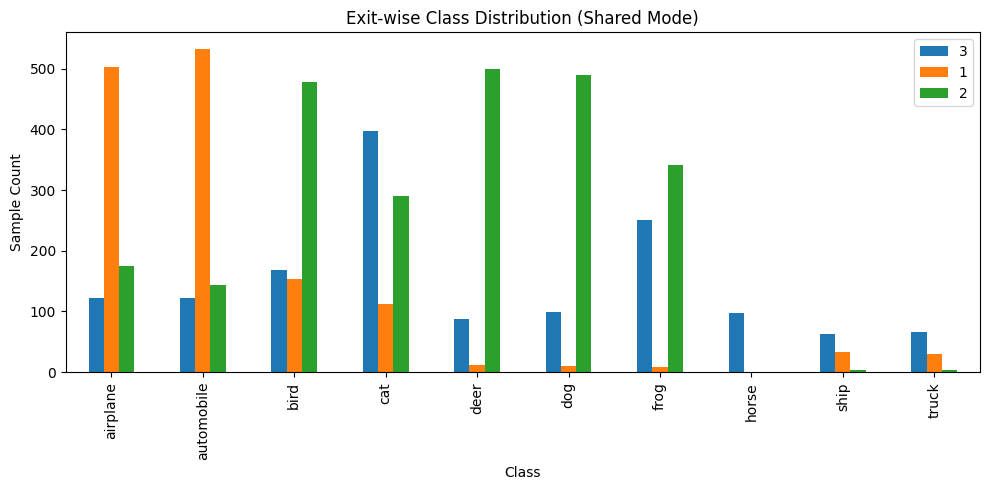

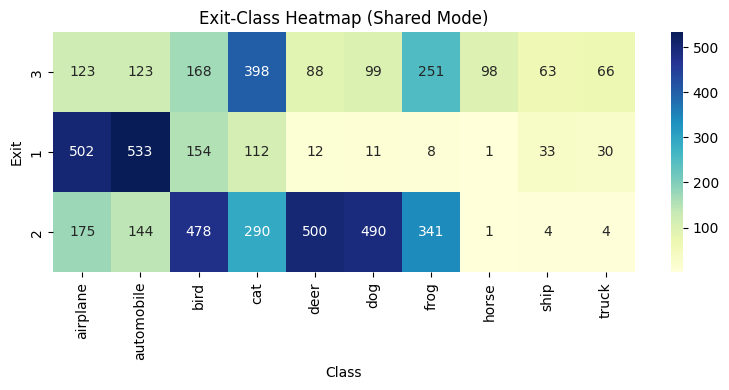


📊 每个出口的总体准确率：
      correct   total  accuracy
exit                           
1      1264.0  1396.0  0.905444
2      2226.0  2427.0  0.917182
3      1104.0  1477.0  0.747461

📚 每个出口的每类准确率（按 true 标签统计）：

📌 Exit 1：
  airplane    : 95.82%
  automobile  : 93.81%
  bird        : 85.06%
  cat         : 79.46%
  deer        : 0.00%
  dog         : 0.00%
  frog        : 0.00%
  horse       : 0.00%
  ship        : 100.00%
  truck       : 100.00%

📌 Exit 2：
  airplane    : 92.00%
  automobile  : 94.44%
  bird        : 87.87%
  cat         : 82.76%
  deer        : 95.20%
  dog         : 93.67%
  frog        : 95.60%
  horse       : 0.00%
  ship        : 100.00%
  truck       : 100.00%

📌 Exit 3：
  airplane    : 48.78%
  automobile  : 61.79%
  bird        : 60.12%
  cat         : 78.14%
  deer        : 63.64%
  dog         : 53.54%
  frog        : 90.44%
  horse       : 98.98%
  ship        : 96.83%
  truck       : 93.94%

📈 每个出口的预测类别分布：


C:\Users\Zhao\AppData\Local\Temp\ipykernel_16096\4047240214.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_stats = df.groupby('exit').apply(


,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
Exit,,,,,,,,,,
1,500,509,138,89,0,0,0,0,74,86
2,173,138,437,270,518,514,347,0,20,10
3,73,80,115,370,72,85,246,193,126,117


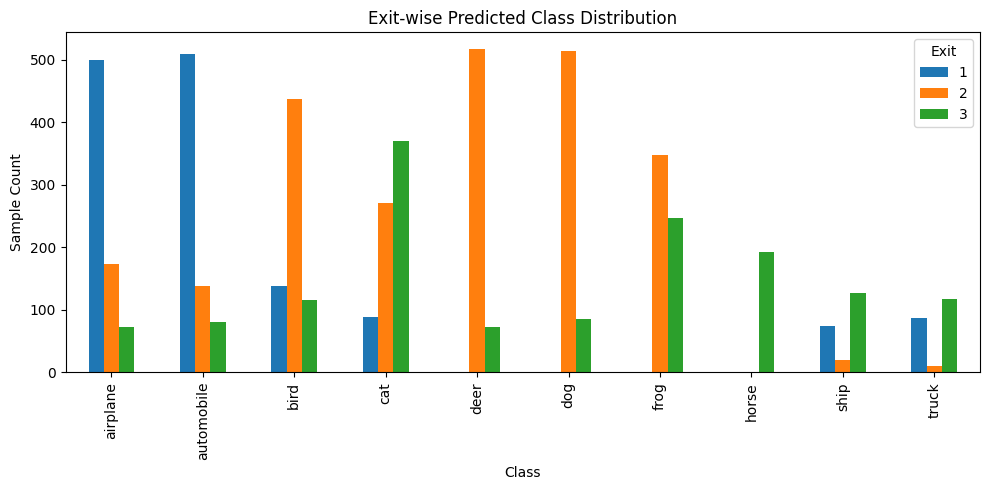

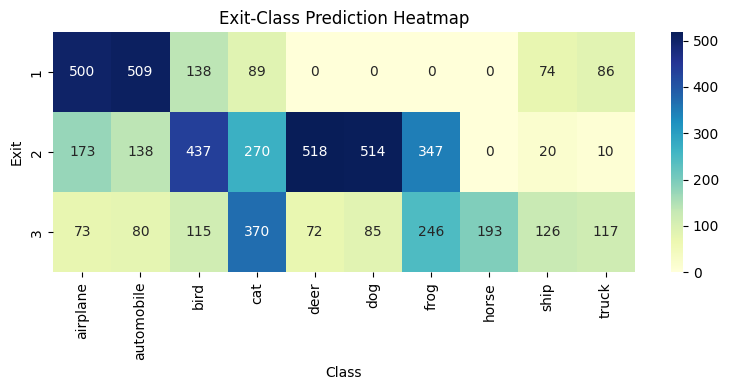

In [35]:
results, latency_logs, exit_logs = run_shared_parallel_execution(
    model_with_exits,
    controller1, controller2,
    new_distribution_loader,
    dataloaders_subset1a, dataloaders_subset1b,
    dataloaders_subset2a, dataloaders_subset2b
)


In [36]:
results

{'Exit1 Training Time (s)': 77.0,
 'Exit2 Training Time (s)': 77.0,
 'Mode': 'Shared Parallel Execution',
 'Inference Duration (s)': 54.8,
 'Avg Inference Latency (s)': 0.0586,
 'Latency Std Dev (s)': 0.081,
 'Threads After': 49,
 'Memory After (MB)': 809.91}

In [25]:
classes_ratios = {
    'airplane': 0.8,    # 4个类别各80%
    'automobile': 0.8,
    'bird': 0.8,
    'cat': 0.8,
    'deer': 0.6,        # 3个类别各60%
    'dog': 0.6,
    'frog': 0.6,
    'horse': 0.4,       # 剩余3个类别各10%
    'ship': 0.4,
    'truck': 0.4
}

# 创建子集

subset = filter_by_samples(test_dataset, classes_ratios, seed=42)

# 查看结果
print(f"Total samples in subset: {len(subset)}")
from collections import Counter

# 获取原始类别分布
original_counts = Counter(test_dataset.targets)

# 获取子集类别分布
subset_labels = [test_dataset.targets[i] for i in subset.indices]
subset_counts = Counter(subset_labels)

# 打印结果
for cls, idx in test_dataset.class_to_idx.items():
    original = original_counts[idx]
    subset_number = subset_counts.get(idx, 0)
    ratio = classes_ratios.get(cls, 0)
    print(f"{cls:10} | Original: {original:4} | Subset: {subset_number:4} | Target Ratio: {ratio:.0%} | Actual Ratio: {subset_number/original:.1%}")
new_distribution_loader= DataLoader(subset, batch_size=64, shuffle=True)

Total samples in subset: 6200
airplane   | Original: 1000 | Subset:  800 | Target Ratio: 80% | Actual Ratio: 80.0%
automobile | Original: 1000 | Subset:  800 | Target Ratio: 80% | Actual Ratio: 80.0%
bird       | Original: 1000 | Subset:  800 | Target Ratio: 80% | Actual Ratio: 80.0%
cat        | Original: 1000 | Subset:  800 | Target Ratio: 80% | Actual Ratio: 80.0%
deer       | Original: 1000 | Subset:  600 | Target Ratio: 60% | Actual Ratio: 60.0%
dog        | Original: 1000 | Subset:  600 | Target Ratio: 60% | Actual Ratio: 60.0%
frog       | Original: 1000 | Subset:  600 | Target Ratio: 60% | Actual Ratio: 60.0%
horse      | Original: 1000 | Subset:  400 | Target Ratio: 40% | Actual Ratio: 40.0%
ship       | Original: 1000 | Subset:  400 | Target Ratio: 40% | Actual Ratio: 40.0%
truck      | Original: 1000 | Subset:  400 | Target Ratio: 40% | Actual Ratio: 40.0%


C:\Users\Zhao\AppData\Local\Temp\ipykernel_23876\2309651438.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_with_exits.pth'))


[C-Shared] 启动训练线程 Exit1 和 Exit2...

Epoch 1/5
----------

Epoch 1/5
----------
[C-Shared] 开始共享模型实时推理记录（auto_select=True）...
Train Loss: 0.3185 | ID Acc: 0.8619 | OOD Certainty: 0.2587

Epoch 2/5
----------
Train Loss: 0.1191 | ID Acc: 0.9850 | OOD Certainty: 0.1266

Epoch 2/5
----------
Train Loss: 0.1999 | ID Acc: 0.9382 | OOD Certainty: 0.2412

Epoch 3/5
----------
Train Loss: 0.0223 | ID Acc: 0.9945 | OOD Certainty: 0.1097

Epoch 3/5
----------

[推理完成]
Train Loss: 0.1763 | ID Acc: 0.9421 | OOD Certainty: 0.2302

[training has been terminated by user]
Train Loss: 0.0169 | ID Acc: 0.9954 | OOD Certainty: 0.1085

[training has been terminated by user]

[可视化] 各出口类别分布：


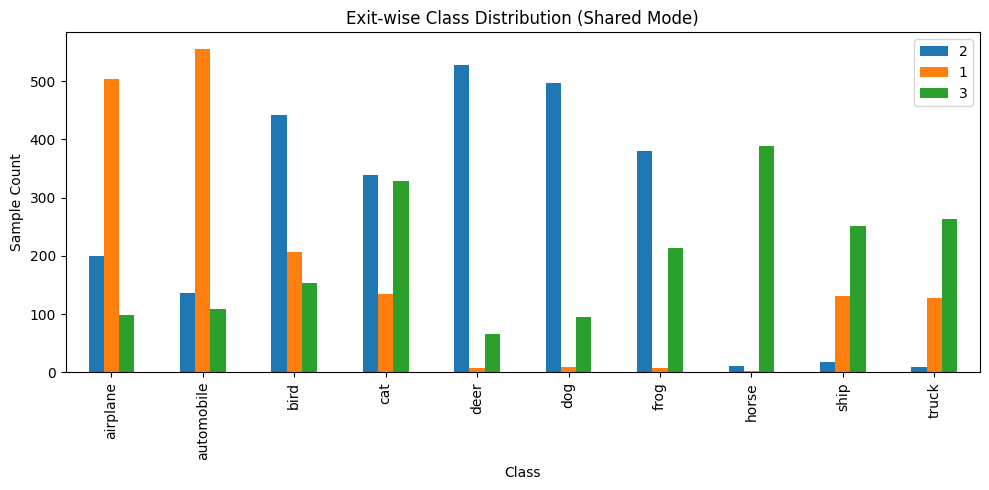

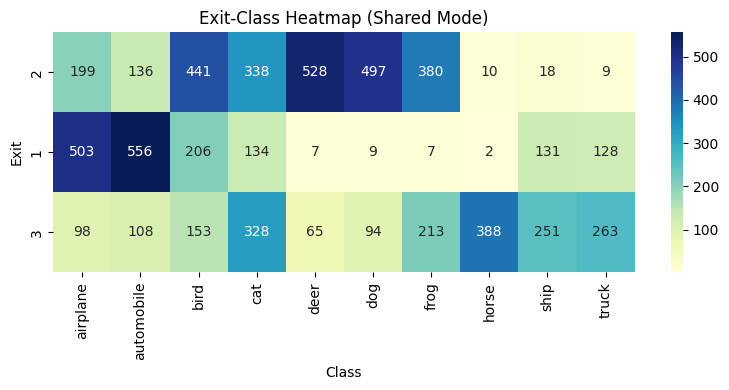


📊 每个出口的总体准确率：
      correct   total  accuracy
exit                           
1      1595.0  1683.0  0.947712
2      2341.0  2556.0  0.915884
3      1633.0  1961.0  0.832738

📚 每个出口的每类准确率（按 true 标签统计）：

📌 Exit 1：
  airplane    : 97.02%
  automobile  : 97.30%
  bird        : 93.20%
  cat         : 94.78%
  deer        : 0.00%
  dog         : 0.00%
  frog        : 0.00%
  horse       : 0.00%
  ship        : 93.89%
  truck       : 96.88%

📌 Exit 2：
  airplane    : 88.94%
  automobile  : 96.32%
  bird        : 90.02%
  cat         : 78.40%
  deer        : 96.97%
  dog         : 95.17%
  frog        : 97.11%
  horse       : 0.00%
  ship        : 77.78%
  truck       : 33.33%

📌 Exit 3：
  airplane    : 47.96%
  automobile  : 63.89%
  bird        : 55.56%
  cat         : 83.84%
  deer        : 63.08%
  dog         : 58.51%
  frog        : 91.55%
  horse       : 96.39%
  ship        : 98.01%
  truck       : 93.54%

📈 每个出口的预测类别分布：


C:\Users\Zhao\AppData\Local\Temp\ipykernel_23876\4047240214.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_stats = df.groupby('exit').apply(


,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
Exit,,,,,,,,,,
1,518,549,204,130,0,0,0,0,139,143
2,205,136,414,292,560,543,380,0,21,5
3,65,77,101,351,59,87,217,428,288,288


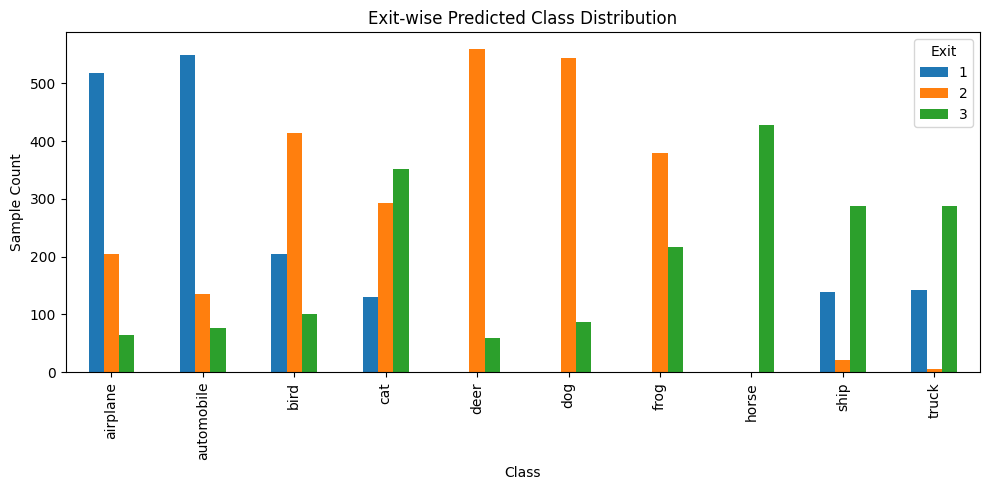

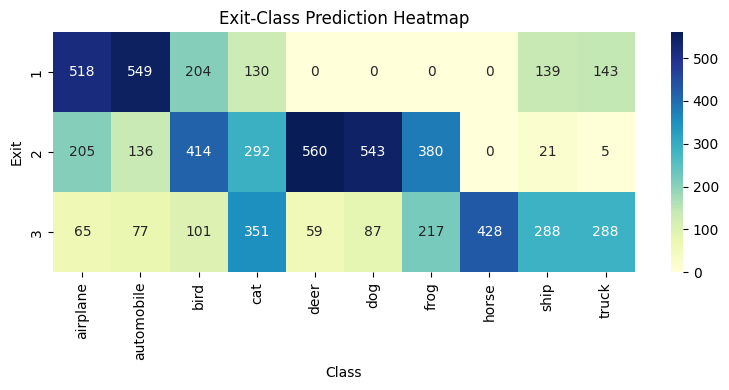

In [26]:
results, latency_logs, exit_logs = run_shared_parallel_execution(
    model_with_exits,
    controller1, controller2,
    new_distribution_loader,
    dataloaders_subset1a, dataloaders_subset1b,
    dataloaders_subset2a, dataloaders_subset2b
)


In [29]:
classes_ratios = {
    'airplane': 0.8,    # 4个类别各80%
    'automobile': 0.8,
    'bird': 0.6,
    'cat': 0.1,
    'deer': 0.6,        # 3个类别各60%
    'dog': 0.6,
    'frog': 0.1,
    'horse': 0.1,       # 剩余3个类别各10%
    'ship': 0.8,
    'truck': 0.8
}

# 创建子集

subset = filter_by_samples(test_dataset, classes_ratios, seed=42)

# 查看结果
print(f"Total samples in subset: {len(subset)}")
from collections import Counter

# 获取原始类别分布
original_counts = Counter(test_dataset.targets)

# 获取子集类别分布
subset_labels = [test_dataset.targets[i] for i in subset.indices]
subset_counts = Counter(subset_labels)

# 打印结果
for cls, idx in test_dataset.class_to_idx.items():
    original = original_counts[idx]
    subset_number = subset_counts.get(idx, 0)
    ratio = classes_ratios.get(cls, 0)
    print(f"{cls:10} | Original: {original:4} | Subset: {subset_number:4} | Target Ratio: {ratio:.0%} | Actual Ratio: {subset_number/original:.1%}")
new_distribution_loader= DataLoader(subset, batch_size=64, shuffle=True)

Total samples in subset: 5300
airplane   | Original: 1000 | Subset:  800 | Target Ratio: 80% | Actual Ratio: 80.0%
automobile | Original: 1000 | Subset:  800 | Target Ratio: 80% | Actual Ratio: 80.0%
bird       | Original: 1000 | Subset:  600 | Target Ratio: 60% | Actual Ratio: 60.0%
cat        | Original: 1000 | Subset:  100 | Target Ratio: 10% | Actual Ratio: 10.0%
deer       | Original: 1000 | Subset:  600 | Target Ratio: 60% | Actual Ratio: 60.0%
dog        | Original: 1000 | Subset:  600 | Target Ratio: 60% | Actual Ratio: 60.0%
frog       | Original: 1000 | Subset:  100 | Target Ratio: 10% | Actual Ratio: 10.0%
horse      | Original: 1000 | Subset:  100 | Target Ratio: 10% | Actual Ratio: 10.0%
ship       | Original: 1000 | Subset:  800 | Target Ratio: 80% | Actual Ratio: 80.0%
truck      | Original: 1000 | Subset:  800 | Target Ratio: 80% | Actual Ratio: 80.0%


C:\Users\Zhao\AppData\Local\Temp\ipykernel_14444\2309651438.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_with_exits.pth'))


[C-Shared] 启动训练线程 Exit1 和 Exit2...

Epoch 1/5
----------

Epoch 1/5
----------
[C-Shared] 开始共享模型实时推理记录（auto_select=True）...
Train Loss: 0.3271 | ID Acc: 0.8565 | OOD Certainty: 0.2571

Epoch 2/5
----------


Exception in thread Thread-12 (_wrapper):
Traceback (most recent call last):
  File "D:\anaconda3\envs\openood\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "D:\anaconda3\envs\openood\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Zhao\AppData\Local\Temp\ipykernel_14444\4087763787.py", line 18, in _wrapper
  File "C:\Users\Zhao\AppData\Local\Temp\ipykernel_14444\2644220026.py", line 69, in trainEE_KL
  File "D:\anaconda3\envs\openood\lib\site-packages\torch\_tensor.py", line 521, in backward
    torch.autograd.backward(
  File "D:\anaconda3\envs\openood\lib\site-packages\torch\autograd\__init__.py", line 289, in backward
    _engine_run_backward(
  File "D:\anaconda3\envs\openood\lib\site-packages\torch\autograd\graph.py", line 769, in _engine_run_backward
    return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
RuntimeError: one of the variables needed for gra

Train Loss: 0.1186 | ID Acc: 0.9842 | OOD Certainty: 0.1266

Epoch 2/5
----------
Train Loss: 0.2064 | ID Acc: 0.9324 | OOD Certainty: 0.2452

Epoch 2/5
----------
Train Loss: 0.1681 | ID Acc: 0.9488 | OOD Certainty: 0.2286

Epoch 3/5
----------
Train Loss: 0.1532 | ID Acc: 0.9580 | OOD Certainty: 0.2203

Epoch 3/5
----------
Train Loss: 0.0221 | ID Acc: 0.9957 | OOD Certainty: 0.1101

Epoch 3/5
----------

[推理完成]
Train Loss: 0.1413 | ID Acc: 0.9610 | OOD Certainty: 0.2134

[training has been terminated by user]
Train Loss: 0.1249 | ID Acc: 0.9683 | OOD Certainty: 0.2064

[training has been terminated by user]

[可视化] 各出口类别分布：


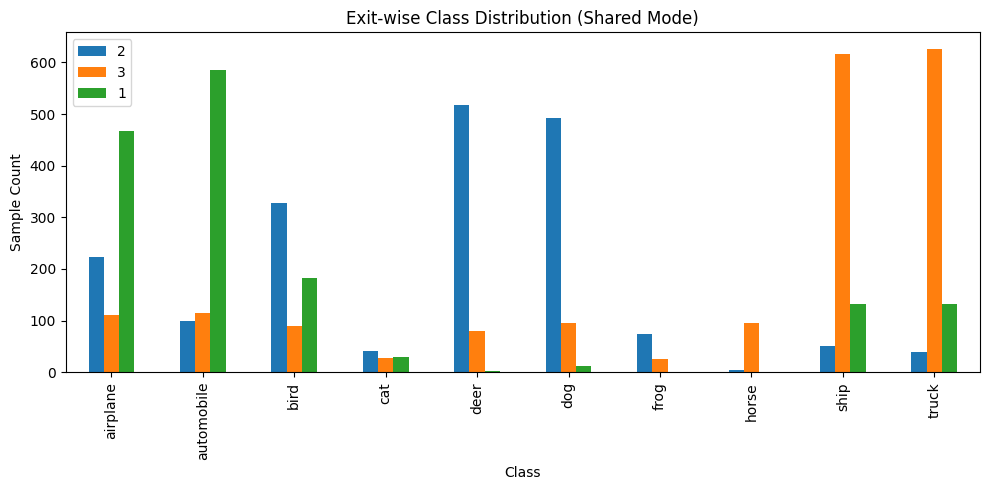

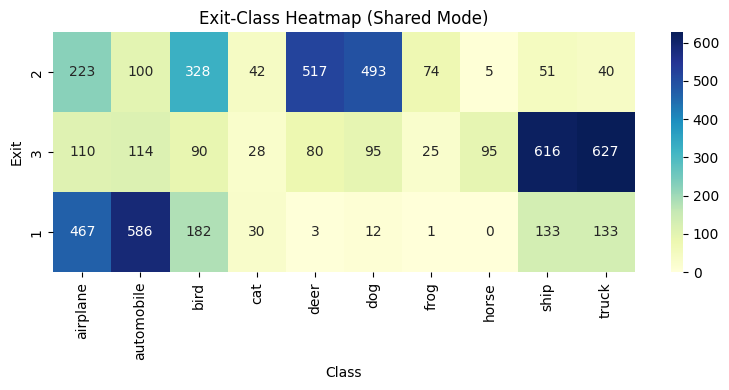


📊 每个出口的准确率：
      correct   total  accuracy
exit                           
1      1464.0  1547.0  0.946348
2      1637.0  1873.0  0.873999
3      1558.0  1880.0  0.828723

📈 每个出口的预测类别分布：


C:\Users\Zhao\AppData\Local\Temp\ipykernel_14444\2481425993.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_stats = df.groupby('exit').apply(


,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
Exit,,,,,,,,,,
1,475,593,181,47,0,0,0,0,119,132
2,195,87,284,124,499,465,156,0,32,31
3,74,86,80,114,60,69,47,173,604,573


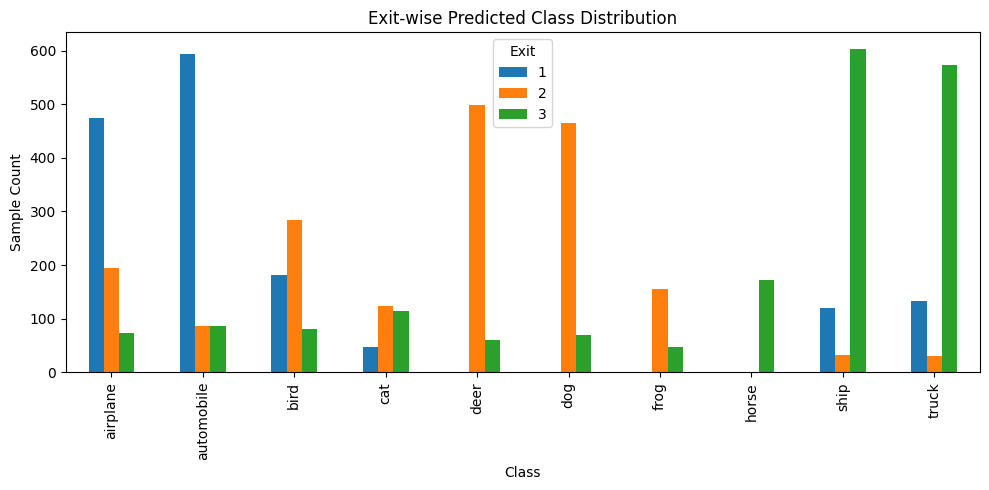

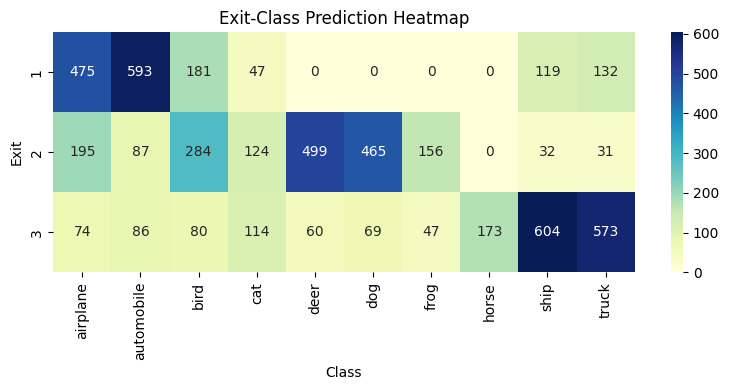

In [30]:
results, latency_logs, exit_logs = run_shared_parallel_execution(
    model_with_exits,
    controller1, controller2,
    new_distribution_loader,
    dataloaders_subset1a, dataloaders_subset1b,
    dataloaders_subset2a, dataloaders_subset2b
)


In [64]:
results, latency_logs

({'Mode': 'Shared Parallel Execution',
  'Inference Duration (s)': 54.87,
  'Avg Inference Latency (s)': 0.0714,
  'Latency Std Dev (s)': 0.0985,
  'Threads After': 55,
  'Memory After (MB)': 769.9},
 [0.5146939754486084,
  0.08522415161132812,
  0.07764816284179688,
  0.08025979995727539,
  0.4716963768005371,
  0.08101701736450195,
  0.10284304618835449,
  0.3235156536102295,
  0.006587982177734375,
  0.006023406982421875,
  0.016306638717651367,
  0.0205690860748291,
  0.11578822135925293,
  0.04235219955444336,
  0.047458648681640625,
  0.053702592849731445,
  0.08437919616699219,
  0.05143570899963379,
  0.08400177955627441,
  0.08991098403930664,
  0.2886965274810791,
  0.23460650444030762,
  0.048767805099487305,
  0.04734992980957031,
  0.018230915069580078,
  0.02435445785522461,
  0.047135353088378906,
  0.04790949821472168,
  0.05159425735473633,
  0.060431718826293945,
  0.18325304985046387,
  0.04214596748352051,
  0.026575565338134766,
  0.030104637145996094,
  0.04415249

## Pattern O

In [45]:
def run_pattern_O_no_training(
    model,
    inference_loader,
    device='cuda'
):
    import time, psutil
    from collections import defaultdict, Counter
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import torch.nn.functional as F

    results = {}
    process = psutil.Process()

    # === 加载模型 ===
    model.load_state_dict(torch.load('model_with_exits.pth'))
    model.eval()

    # === 推理记录结构 ===
    exit_logs = defaultdict(list)
    latency_logs = []
    all_logs = {'true': [], 'pred': [], 'exit': []}

    print("[Pattern-O] 开始推理记录（无训练线程，auto_select=True）...")
    start_infer_time = time.time()

    for batch in inference_loader:
        images, labels = batch[0].to(device), batch[1].to(device)
        try:
            start = time.time()
            with torch.no_grad():
                outputs, exit_idx = model(images, auto_select=True)
            end = time.time()
            latency_logs.append(end - start)

            probs = F.softmax(outputs, dim=1)
            confs, preds = torch.max(probs, dim=1)

            for i in range(len(exit_idx)):
                exit_number = exit_idx[i].item()
                true_label = labels[i].item()
                pred_label = preds[i].item()

                exit_logs[exit_number].append(true_label)
                all_logs['true'].append(true_label)
                all_logs['pred'].append(pred_label)
                all_logs['exit'].append(exit_number)

            time.sleep(0.5)
        except Exception as e:
            print(f"[ERROR] 推理失败: {e}")

    infer_duration = time.time() - start_infer_time
    print("\n[推理完成]")

    # === 系统资源与性能记录 ===
    mem_after = process.memory_info().rss / 1024 ** 2
    threads_after = process.num_threads()

    results["Mode"] = "Pattern-O (No Training)"
    results["Inference Duration (s)"] = round(infer_duration, 2)
    results["Avg Inference Latency (s)"] = round(np.mean(latency_logs), 4)
    results["Latency Std Dev (s)"] = round(np.std(latency_logs), 4)
    results["Threads After"] = threads_after
    results["Memory After (MB)"] = round(mem_after, 2)
    print("\n[可视化] 各出口类别分布：")

    _visualize_exit_distribution(exit_logs, title_suffix="(Shared Mode)")
#     class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
#                    'dog', 'frog', 'horse', 'ship', 'truck']
#     exit_class_dist = pd.DataFrame.from_dict(
#         {k: Counter(v) for k, v in exit_logs.items()},
#         orient='index'
#     ).fillna(0).astype(int)

#     for i in range(len(class_names)):
#         if i not in exit_class_dist.columns:
#             exit_class_dist[i] = 0
#     exit_class_dist = exit_class_dist[sorted(exit_class_dist.columns)]
#     exit_class_dist.columns = class_names


#     exit_class_dist.T.plot(kind='bar', figsize=(10, 5))
#     plt.title("Exit-wise Class Distribution (Pattern-O)")
#     plt.xlabel("Class")
#     plt.ylabel("Sample Count")
#     plt.tight_layout()
#     plt.show()

#     plt.figure(figsize=(8, 4))
#     sns.heatmap(exit_class_dist, annot=True, fmt='d', cmap='YlGnBu')
#     plt.title("Exit-Class Heatmap (Pattern-O)")
#     plt.ylabel("Exit")
#     plt.xlabel("Class")
#     plt.tight_layout()
#     plt.show()

    analyze_exit_logs_with_accuracy(all_logs, class_names)

    return results, latency_logs, exit_logs


C:\Users\Zhao\AppData\Local\Temp\ipykernel_16096\4094778820.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_with_exits.pth'))


[Pattern-O] 开始推理记录（无训练线程，auto_select=True）...

[推理完成]

[可视化] 各出口类别分布：


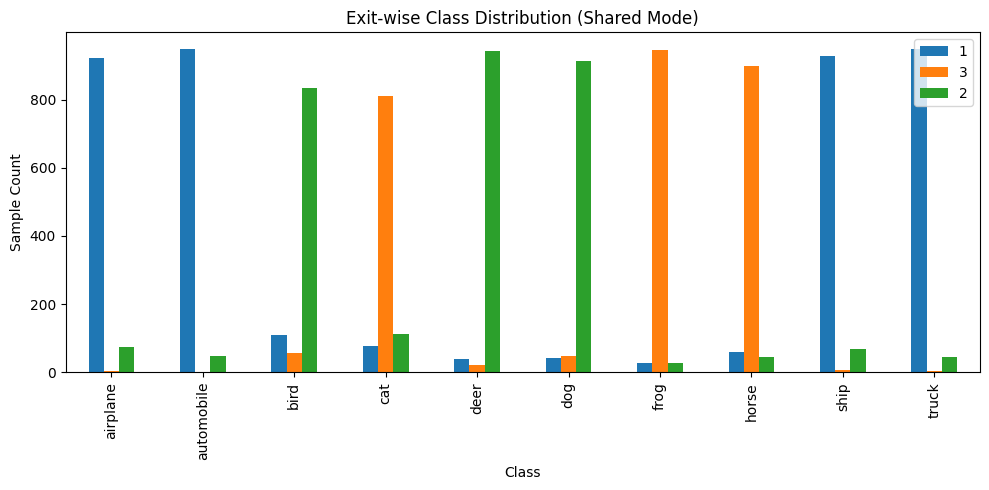

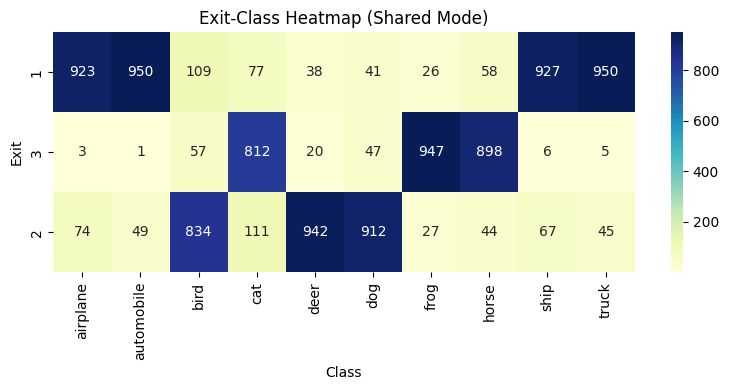


📊 每个出口的总体准确率：
      correct   total  accuracy
exit                           
1      3622.0  4099.0  0.883630
2      2794.0  3105.0  0.899839
3      2647.0  2796.0  0.946710

📚 每个出口的每类准确率（按 true 标签统计）：

📌 Exit 1：
  airplane    : 95.99%
  automobile  : 96.63%
  bird        : 0.00%
  cat         : 0.00%
  deer        : 0.00%
  dog         : 0.00%
  frog        : 0.00%
  horse       : 0.00%
  ship        : 96.22%
  truck       : 97.47%

📌 Exit 2：
  airplane    : 89.19%
  automobile  : 93.88%
  bird        : 93.29%
  cat         : 0.00%
  deer        : 97.13%
  dog         : 98.25%
  frog        : 0.00%
  horse       : 0.00%
  ship        : 89.55%
  truck       : 73.33%

📌 Exit 3：
  airplane    : 0.00%
  automobile  : 100.00%
  bird        : 52.63%
  cat         : 96.06%
  deer        : 45.00%
  dog         : 21.28%
  frog        : 97.99%
  horse       : 98.44%
  ship        : 16.67%
  truck       : 80.00%

📈 每个出口的预测类别分布：


C:\Users\Zhao\AppData\Local\Temp\ipykernel_16096\4047240214.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_stats = df.groupby('exit').apply(


,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
Exit,,,,,,,,,,
1,1100,976,0,0,0,0,0,0,971,1052
2,124,61,801,0,975,1029,0,0,73,42
3,2,3,53,845,19,23,948,896,2,5


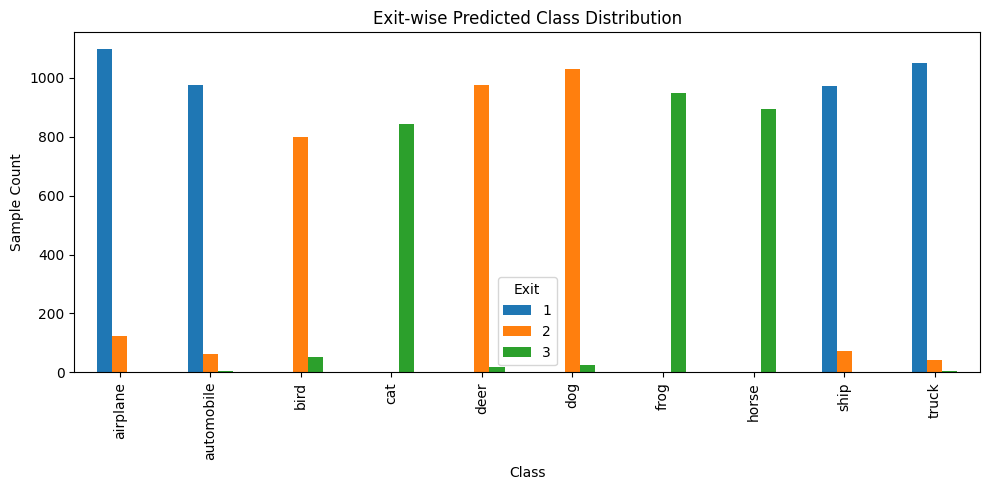

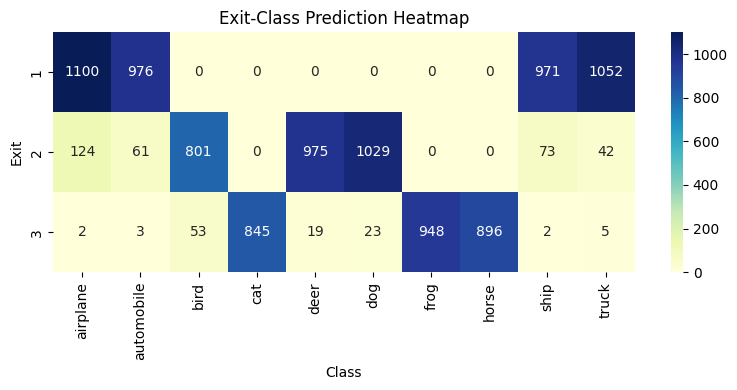

In [41]:
results, latency_logs, exit_logs = run_pattern_O_no_training(
    model_with_exits,
    test_loader
)


In [42]:
results

{'Mode': 'Pattern-O (No Training)',
 'Inference Duration (s)': 88.79,
 'Avg Inference Latency (s)': 0.0473,
 'Latency Std Dev (s)': 0.0629,
 'Threads After': 46,
 'Memory After (MB)': 804.65}

C:\Users\Zhao\AppData\Local\Temp\ipykernel_16096\4094778820.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_with_exits.pth'))


[Pattern-O] 开始推理记录（无训练线程，auto_select=True）...

[推理完成]

[可视化] 各出口类别分布：


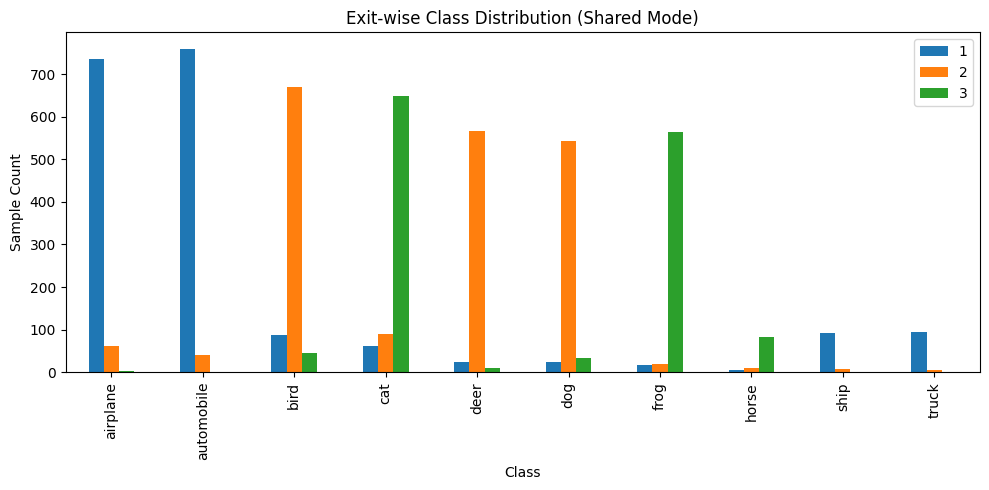

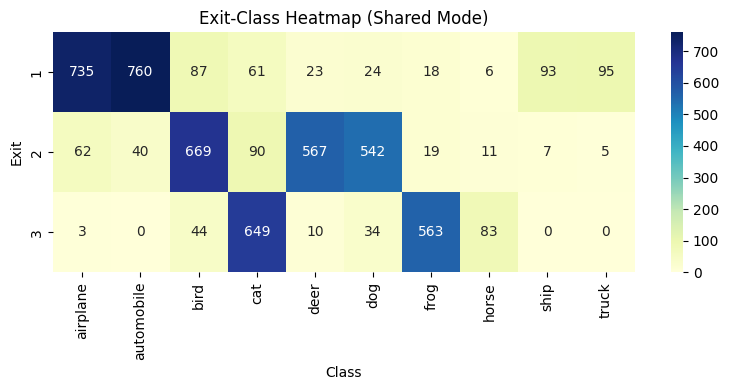


📊 每个出口的总体准确率：
      correct   total  accuracy
exit                           
1      1627.0  1902.0  0.855415
2      1801.0  2012.0  0.895129
3      1301.0  1386.0  0.938672

📚 每个出口的每类准确率（按 true 标签统计）：

📌 Exit 1：
  airplane    : 95.92%
  automobile  : 96.84%
  bird        : 0.00%
  cat         : 0.00%
  deer        : 0.00%
  dog         : 0.00%
  frog        : 0.00%
  horse       : 0.00%
  ship        : 97.85%
  truck       : 100.00%

📌 Exit 2：
  airplane    : 88.71%
  automobile  : 95.00%
  bird        : 92.38%
  cat         : 0.00%
  deer        : 96.83%
  dog         : 97.97%
  frog        : 0.00%
  horse       : 0.00%
  ship        : 71.43%
  truck       : 100.00%

📌 Exit 3：
  airplane    : 0.00%
  automobile  : 0.00%
  bird        : 52.27%
  cat         : 97.07%
  deer        : 50.00%
  dog         : 17.65%
  frog        : 98.58%
  horse       : 98.80%
  ship        : 0.00%
  truck       : 0.00%

📈 每个出口的预测类别分布：


C:\Users\Zhao\AppData\Local\Temp\ipykernel_16096\4047240214.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_stats = df.groupby('exit').apply(


,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
Exit,,,,,,,,,,
1,830,764,0,0,0,0,0,0,143,165
2,95,41,631,0,594,626,0,0,13,12
3,0,1,32,668,10,13,568,93,0,1


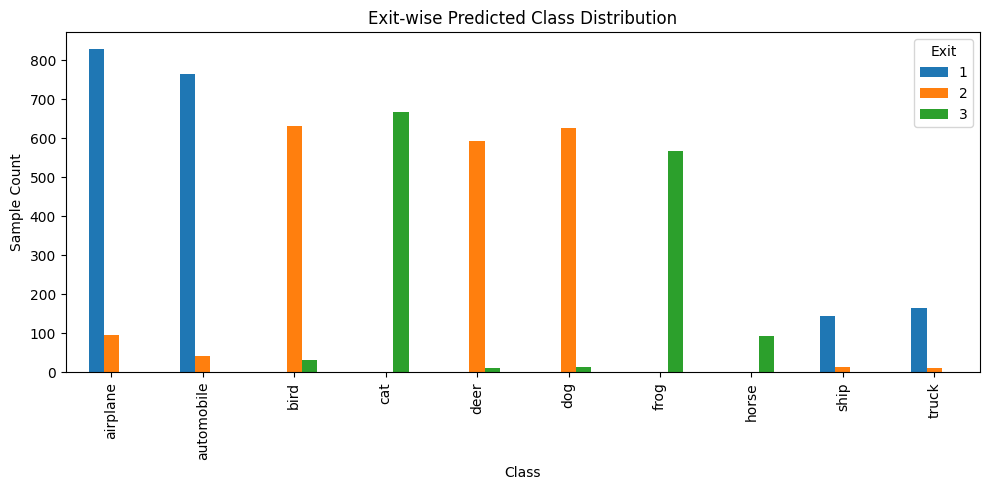

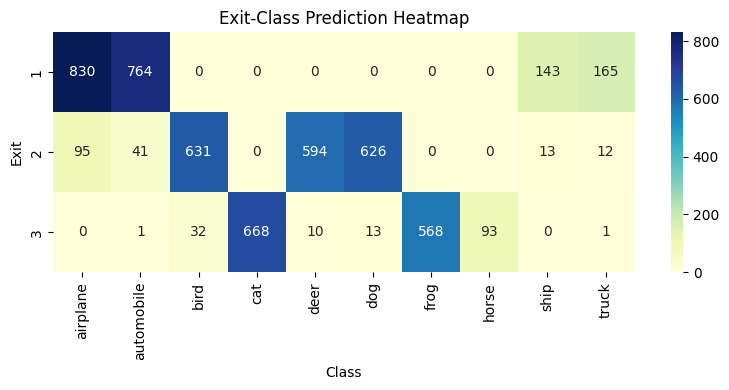

In [43]:
results, latency_logs, exit_logs = run_pattern_O_no_training(
    model_with_exits,
    new_distribution_loader
)

In [44]:
results

{'Mode': 'Pattern-O (No Training)',
 'Inference Duration (s)': 46.65,
 'Avg Inference Latency (s)': 0.0432,
 'Latency Std Dev (s)': 0.0506,
 'Threads After': 46,
 'Memory After (MB)': 817.67}

## Profiler


In [18]:
def run_with_profiler(run_fn, log_name='default_profiler_log', steps=5, *args, **kwargs):
    """
    Run a given function with torch.profiler enabled, tracing CPU/CUDA performance.

    Parameters:
    - run_fn: the target function to execute (e.g., run_shared_parallel_execution)
    - log_name: the output directory name for the profiler logs (under ./log/)
    - steps: how many steps of profiling to activate (affects visualization granularity)
    - *args, **kwargs: arguments to pass to run_fn

    Returns:
    - the result of run_fn(*args, **kwargs)
    """
    import os
    from torch.profiler import profile, ProfilerActivity, tensorboard_trace_handler
    os.makedirs(f'./log/{log_name}', exist_ok=True)

    with profile(
        activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
        schedule=torch.profiler.schedule(wait=1, warmup=1, active=steps),
        on_trace_ready=tensorboard_trace_handler(f'./log/{log_name}'),
        record_shapes=True,
        profile_memory=True,
        with_stack=True
    ) as prof:
        result = run_fn(*args, **kwargs)
        for _ in range(steps):
            prof.step()

    return result

C:\Users\Zhao\AppData\Local\Temp\ipykernel_16288\2309651438.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_with_exits.pth'))


[C-Shared] 启动训练线程 Exit1 和 Exit2...

Epoch 1/5
----------

Epoch 1/5
----------
[C-Shared] 开始共享模型实时推理记录（auto_select=True）...
Train Loss: 0.3222 | ID Acc: 0.8598 | OOD Certainty: 0.2575

Epoch 2/5
----------
Train Loss: 0.1241 | ID Acc: 0.9836 | OOD Certainty: 0.1260

Epoch 2/5
----------
Train Loss: 0.1981 | ID Acc: 0.9367 | OOD Certainty: 0.2431

Epoch 3/5
----------
Train Loss: 0.0217 | ID Acc: 0.9950 | OOD Certainty: 0.1094

Epoch 3/5
----------
Train Loss: 0.1674 | ID Acc: 0.9522 | OOD Certainty: 0.2273

Epoch 4/5
----------
Train Loss: 0.0171 | ID Acc: 0.9955 | OOD Certainty: 0.1078

Epoch 4/5
----------
Train Loss: 0.1522 | ID Acc: 0.9578 | OOD Certainty: 0.2216

Epoch 5/5
----------

[推理完成]
Train Loss: 0.0177 | ID Acc: 0.9955 | OOD Certainty: 0.1072

Epoch 5/5
----------
Train Loss: 0.1415 | ID Acc: 0.9633 | OOD Certainty: 0.2145
Train Loss: 0.0133 | ID Acc: 0.9961 | OOD Certainty: 0.1060

[可视化] 各出口类别分布：


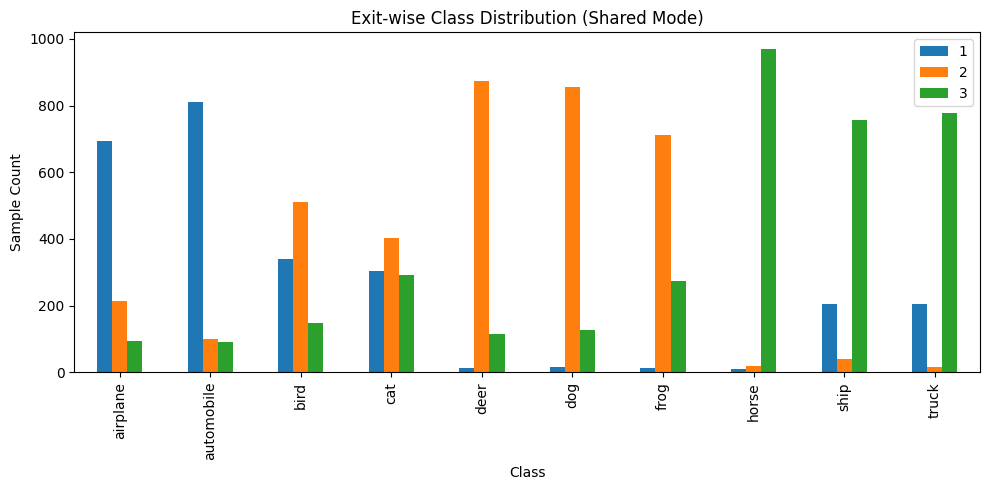

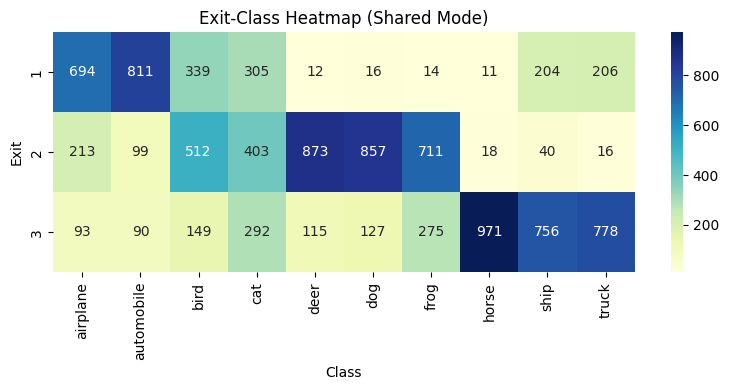


📊 每个出口的准确率：
      correct   total  accuracy
exit                           
1      2440.0  2612.0  0.934150
2      3424.0  3742.0  0.915019
3      3246.0  3646.0  0.890291

📈 每个出口的预测类别分布：


C:\Users\Zhao\AppData\Local\Temp\ipykernel_16288\2481425993.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_stats = df.groupby('exit').apply(


,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
Exit,,,,,,,,,,
1,742,853,325,315,0,0,0,0,185,192
2,237,101,487,418,873,870,713,0,30,13
3,97,61,142,330,93,102,272,1002,783,764


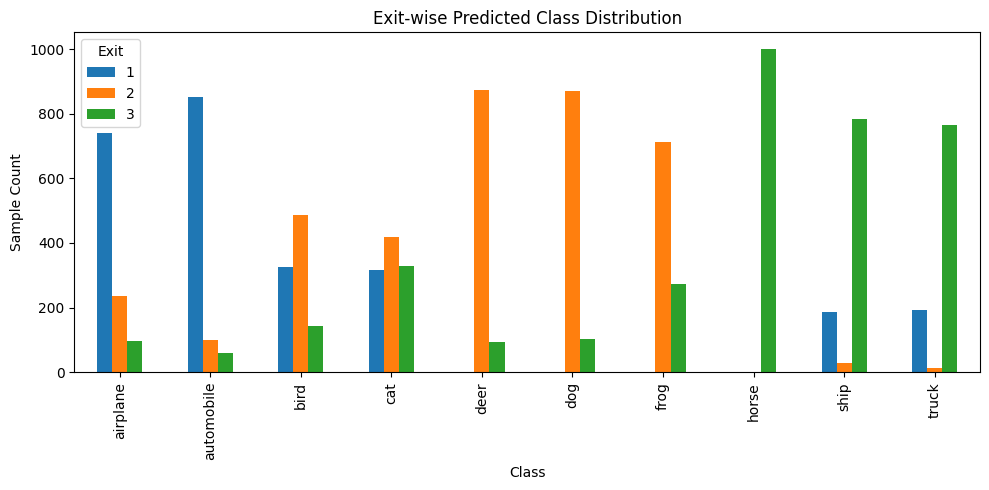

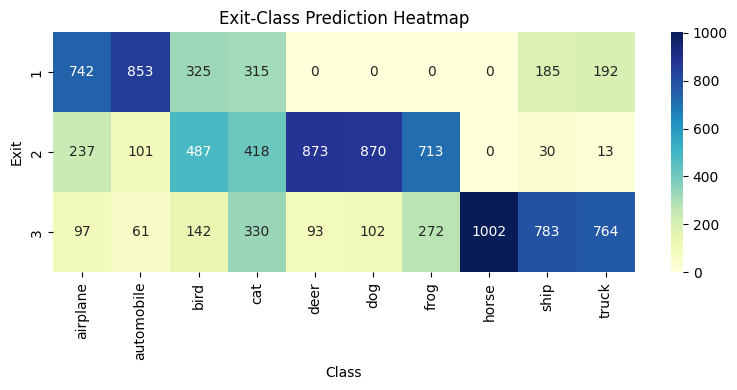

({'Mode': 'Shared Parallel Execution',
  'Inference Duration (s)': 102.27,
  'Avg Inference Latency (s)': 0.0611,
  'Latency Std Dev (s)': 0.078,
  'Threads After': 48,
  'Memory After (MB)': 1749.69},
 [0.487231969833374,
  0.0053255558013916016,
  0.005450725555419922,
  0.014990568161010742,
  0.30509161949157715,
  0.032147884368896484,
  0.042623281478881836,
  0.040667057037353516,
  0.39074254035949707,
  0.0787343978881836,
  0.07207965850830078,
  0.274169921875,
  0.14165854454040527,
  0.005513668060302734,
  0.006037712097167969,
  0.04579758644104004,
  0.017815828323364258,
  0.01901388168334961,
  0.023719072341918945,
  0.05134844779968262,
  0.12169837951660156,
  0.07861638069152832,
  0.09041380882263184,
  0.04639863967895508,
  0.0344538688659668,
  0.07500672340393066,
  0.3234226703643799,
  0.005352973937988281,
  0.0061681270599365234,
  0.006102800369262695,
  0.01704239845275879,
  0.016684293746948242,
  0.03320884704589844,
  0.024135112762451172,
  0.03330

In [19]:
run_with_profiler(
    run_fn=run_shared_parallel_execution,
    log_name='prof_modeC',
    steps=5,
    model=model_with_exits,
    controller1=controller1,
    controller2=controller2,
    inference_loader=test_loader,
    dataloaders_subset1a=dataloaders_subset1a,
    dataloaders_subset1b=dataloaders_subset1b,
    dataloaders_subset2a=dataloaders_subset2a,
    dataloaders_subset2b=dataloaders_subset2b,
    device='cuda'
)


In [22]:
%load_ext tensorboard
%tensorboard --logdir ./log/prof_modeC


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 25476), started 0:40:41 ago. (Use '!kill 25476' to kill it.)

In [23]:
%tensorboard --logdir ./log

Reusing TensorBoard on port 6006 (pid 27996), started 1:18:12 ago. (Use '!kill 27996' to kill it.)

In [24]:
import os

for root, dirs, files in os.walk("./log"):
    print(f"\n📂 Folder: {root}")
    for file in files:
        print(f" - {file}")


📂 Folder: ./log

📂 Folder: ./log\prof_modeC
 - DESKTOP-KF5T7HO_14444.1747324009445417200.pt.trace.json
 - DESKTOP-KF5T7HO_16288.1747324775499465900.pt.trace.json


In [26]:
model = nn.Linear(10, 10).cuda()
x = torch.randn(5, 10).cuda()

with torch.profiler.profile(
    activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
    schedule=torch.profiler.schedule(wait=0, warmup=1, active=3),
    on_trace_ready=torch.profiler.tensorboard_trace_handler('./log/minitest'),
    record_shapes=True,
    profile_memory=True
) as prof:
    for i in range(5):
        y = model(x)
        y.sum().backward()
        prof.step()

In [27]:
%tensorboard --logdir=./log